In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('leader_stocks_data/KT&G_기타제조업.csv')
df = df.set_index(keys=['Date'], inplace=False, drop=True)
df = df.drop('Close', axis = 1)
df.rename(columns ={'Adj Close':'Close'}, inplace = True)

In [3]:
df.isnull().sum()

High      0
Low       0
Open      0
Volume    0
Close     0
dtype: int64

In [15]:
df[-5700:]

,High,Low,Open,Volume,Close
Date,,,,,
2000-01-04,24000.0,21350.0,21350.0,309700.0,7718.005371
2000-01-05,22950.0,21400.0,22200.0,431700.0,7577.678223
2000-01-06,22200.0,20800.0,21650.0,379400.0,7349.646484
2000-01-07,21500.0,20200.0,20450.0,356400.0,7156.696289
2000-01-10,21000.0,20300.0,20550.0,327400.0,7156.696289
...,...,...,...,...,...
2022-06-20,83700.0,82100.0,83500.0,246936.0,82500.000000
2022-06-21,83400.0,82600.0,83100.0,206625.0,83100.000000
2022-06-22,83700.0,82100.0,83300.0,274579.0,82200.000000


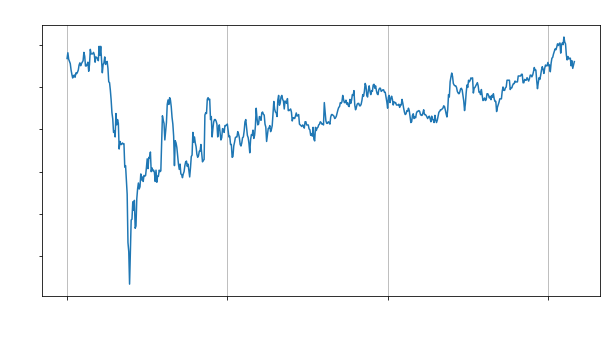

In [62]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize = (10,5))
ax = plt.subplot()
plt.title("KT&G_기타제조업", fontsize=15, color = 'white')
plt.plot(df['Close'], "-", label="Close")
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
ax.xaxis.set_major_locator(plt.MultipleLocator(200))
plt.xticks(rotation=45)
plt.grid(axis = 'x')
plt.show()

In [35]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

result = []
df_origin = pd.read_csv('leader_stocks_data/KT&G_기타제조업.csv')
for i in range(2, len(df_origin)//100+2):
    # 데이터 불러오기
    df = pd.read_csv('leader_stocks_data/KT&G_기타제조업.csv')
    df = df.set_index(keys=['Date'], inplace=False, drop=True)
    df = df.drop('Close', axis = 1)
    df.rename(columns ={'Adj Close':'Close'}, inplace = True)
    # 원하는 크기로 데이터 자르기
    df = df[-i*100:]
    # 피처값, 타켓 스케일링
    scaler = MinMaxScaler()
    df[['High','Low','Open', 'Volume']] = scaler.fit_transform(df[['High','Low','Open', 'Volume']])
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
    # train, test set 분리
    x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)
    print('train set 확인: ' ,  x_train.shape, y_train.shape, 'test set 확인: ',  x_test.shape, y_test.shape)

    train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
    test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False) 
    # lstm 모델링
    model = Sequential([
        Conv1D(filters=32, kernel_size=5,
               padding="causal",
               activation="relu",
               input_shape=[WINDOW_SIZE, 1]),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])
    loss = Huber()
    optimizer = Adam(0.0005)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse']) 
    earlystopping = EarlyStopping(monitor='val_loss', patience=10) 
    # lstm 적용                                        
    history = model.fit(train_data, 
                        validation_data=(test_data), 
                        epochs=50, 
                        callbacks=[earlystopping])
    pred = model.predict(test_data)
    print(f"pred.shape : {pred.shape} , y_test.shape : {y_test.shape}")
    # rescaleing 작업
    rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
    rescaled_pred = scaler.inverse_transform(np.array(pred).reshape(-1,1))
    # 평가지표(RMSE) 계산
    RMSE = np.sqrt(mean_squared_error(rescaled_y_test[20:], rescaled_pred))
    result.append(RMSE)
    print(f"{i * 100}길이의 데이터 적용 완료\n 길이: {i * 100}, RMSE:{RMSE}")
    result   

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


train set 확인:  (160, 4) (160,) test set 확인:  (40, 4) (40,)
Epoch 1/50
5/5 [==============================] - 6s 340ms/step - loss: 0.0818 - mse: 0.1636 - val_loss: 0.3002 - val_mse: 0.6003
Epoch 2/50
5/5 [==============================] - 0s 49ms/step - loss: 0.0656 - mse: 0.1311 - val_loss: 0.2507 - val_mse: 0.5015
Epoch 3/50
5/5 [==============================] - 0s 39ms/step - loss: 0.0525 - mse: 0.1050 - val_loss: 0.2063 - val_mse: 0.4126
Epoch 4/50
5/5 [==============================] - 0s 43ms/step - loss: 0.0407 - mse: 0.0813 - val_loss: 0.1665 - val_mse: 0.3329
Epoch 5/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0296 - mse: 0.0592 - val_loss: 0.1263 - val_mse: 0.2525
Epoch 6/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0197 - mse: 0.0394 - val_loss: 0.0926 - val_mse: 0.1851
Epoch 7/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0126 - mse: 0.0253 - val_loss: 0.0646 - val_mse: 0.1292
Epoch 8/50
5/5 [=====================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
7/7 [==============================] - 6s 233ms/step - loss: 0.0279 - mse: 0.0559 - val_loss: 0.1309 - val_mse: 0.2618
Epoch 2/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0157 - mse: 0.0314 - val_loss: 0.0810 - val_mse: 0.1620
Epoch 3/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0092 - mse: 0.0183 - val_loss: 0.0471 - val_mse: 0.0942
Epoch 4/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0050 - mse: 0.0100 - val_loss: 0.0244 - val_mse: 0.0489
Epoch 5/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0040 - mse: 0.0080 - val_loss: 0.0135 - val_mse: 0.0270
Epoch 6/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0041 - mse: 0.0083 - val_loss: 0.0118 - val_mse: 0.0237
Epoch 7/50
7/7 [==============================] - 0s 31ms/step - loss: 0.0040 - mse: 0.0079 - val_loss: 0.0153 - val_mse: 0.0306
Epoch 8/50
7/7 [==============================] - 0s 32ms/step - loss: 0.0037 - mse: 0.0073 - va

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
10/10 [==============================] - 6s 141ms/step - loss: 0.0640 - mse: 0.1280 - val_loss: 0.2388 - val_mse: 0.4776
Epoch 2/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0477 - mse: 0.0954 - val_loss: 0.1883 - val_mse: 0.3767
Epoch 3/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0338 - mse: 0.0676 - val_loss: 0.1410 - val_mse: 0.2820
Epoch 4/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0208 - mse: 0.0417 - val_loss: 0.0935 - val_mse: 0.1870
Epoch 5/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0101 - mse: 0.0202 - val_loss: 0.0481 - val_mse: 0.0962
Epoch 6/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0042 - mse: 0.0085 - val_loss: 0.0203 - val_mse: 0.0405
Epoch 7/50
10/10 [==============================] - 0s 25ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0157 - val_mse: 0.0314
Epoch 8/50
10/10 [==============================] - 0s 22ms/step - loss: 0.0035 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
12/12 [==============================] - 5s 116ms/step - loss: 0.0901 - mse: 0.1803 - val_loss: 0.2022 - val_mse: 0.4044
Epoch 2/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0592 - mse: 0.1184 - val_loss: 0.1390 - val_mse: 0.2781
Epoch 3/50
12/12 [==============================] - 0s 27ms/step - loss: 0.0341 - mse: 0.0682 - val_loss: 0.0802 - val_mse: 0.1603
Epoch 4/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0123 - mse: 0.0245 - val_loss: 0.0286 - val_mse: 0.0571
Epoch 5/50
12/12 [==============================] - 0s 27ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 0.0079 - val_mse: 0.0157
Epoch 6/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 0.0112 - val_mse: 0.0224
Epoch 7/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0135 - val_mse: 0.0271
Epoch 8/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0027 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
15/15 [==============================] - 6s 106ms/step - loss: 0.1200 - mse: 0.2400 - val_loss: 0.1244 - val_mse: 0.2487
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0307 - mse: 0.0614 - val_loss: 0.0209 - val_mse: 0.0417
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0073 - val_loss: 0.0024 - val_mse: 0.0049
Epoch 4/50
15/15 [==============================] - 1s 29ms/step - loss: 0.0030 - mse: 0.0060 - val_loss: 0.0083 - val_mse: 0.0165
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0027 - mse: 0.0054 - val_loss: 0.0048 - val_mse: 0.0097
Epoch 6/50
15/15 [==============================] - 1s 26ms/step - loss: 0.0026 - mse: 0.0052 - val_loss: 0.0058 - val_mse: 0.0116
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0051 - val_loss: 0.0046 - val_mse: 0.0091
Epoch 8/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0024 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
17/17 [==============================] - 6s 85ms/step - loss: 0.0420 - mse: 0.0840 - val_loss: 0.0037 - val_mse: 0.0074
Epoch 2/50
17/17 [==============================] - 1s 26ms/step - loss: 0.0039 - mse: 0.0078 - val_loss: 5.2309e-04 - val_mse: 0.0010
Epoch 3/50
17/17 [==============================] - 1s 25ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 4/50
17/17 [==============================] - 1s 25ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 6.1940e-04 - val_mse: 0.0012
Epoch 5/50
17/17 [==============================] - 1s 26ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 6/50
17/17 [==============================] - 1s 27ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 8.2016e-04 - val_mse: 0.0016
Epoch 7/50
17/17 [==============================] - 1s 24ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 7.3246e-04 - val_mse: 0.0015
Epoch 8/50
17/17 [==============================] - 1s 24ms/step - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
20/20 [==============================] - 7s 96ms/step - loss: 0.1344 - mse: 0.2689 - val_loss: 0.0750 - val_mse: 0.1501
Epoch 2/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0202 - mse: 0.0403 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 3/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0048 - mse: 0.0096 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 4/50
20/20 [==============================] - 1s 23ms/step - loss: 0.0029 - mse: 0.0058 - val_loss: 9.1908e-04 - val_mse: 0.0018
Epoch 5/50
20/20 [==============================] - 1s 23ms/step - loss: 0.0024 - mse: 0.0048 - val_loss: 6.7668e-04 - val_mse: 0.0014
Epoch 6/50
20/20 [==============================] - 1s 22ms/step - loss: 0.0021 - mse: 0.0041 - val_loss: 6.1561e-04 - val_mse: 0.0012
Epoch 7/50
20/20 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 6.1444e-04 - val_mse: 0.0012
Epoch 8/50
20/20 [==============================] - 0s 21ms/step - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
22/22 [==============================] - 7s 73ms/step - loss: 0.0951 - mse: 0.1902 - val_loss: 0.0198 - val_mse: 0.0396
Epoch 2/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0063 - mse: 0.0126 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 3/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 6.6624e-04 - val_mse: 0.0013
Epoch 4/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 4.2046e-04 - val_mse: 8.4092e-04
Epoch 5/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 4.1118e-04 - val_mse: 8.2236e-04
Epoch 6/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 3.9610e-04 - val_mse: 7.9220e-04
Epoch 7/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 3.7403e-04 - val_mse: 7.4807e-04
Epoch 8/50
22/22 [=============================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
25/25 [==============================] - 6s 67ms/step - loss: 0.1632 - mse: 0.3265 - val_loss: 0.0600 - val_mse: 0.1200
Epoch 2/50
25/25 [==============================] - 1s 25ms/step - loss: 0.0239 - mse: 0.0477 - val_loss: 5.5558e-04 - val_mse: 0.0011
Epoch 3/50
25/25 [==============================] - 1s 20ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 5.3570e-04 - val_mse: 0.0011
Epoch 4/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 5.2001e-04 - val_mse: 0.0010
Epoch 5/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0023 - mse: 0.0045 - val_loss: 4.5762e-04 - val_mse: 9.1523e-04
Epoch 6/50
25/25 [==============================] - 1s 20ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 4.4562e-04 - val_mse: 8.9124e-04
Epoch 7/50
25/25 [==============================] - 1s 23ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 4.2701e-04 - val_mse: 8.5401e-04
Epoch 8/50
25/25 [=============================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
27/27 [==============================] - 6s 62ms/step - loss: 0.1361 - mse: 0.2722 - val_loss: 0.0610 - val_mse: 0.1220
Epoch 2/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0254 - mse: 0.0509 - val_loss: 6.9495e-04 - val_mse: 0.0014
Epoch 3/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 5.5408e-04 - val_mse: 0.0011
Epoch 4/50
27/27 [==============================] - 1s 20ms/step - loss: 0.0024 - mse: 0.0048 - val_loss: 5.0204e-04 - val_mse: 0.0010
Epoch 5/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0021 - mse: 0.0042 - val_loss: 4.4691e-04 - val_mse: 8.9382e-04
Epoch 6/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 4.0717e-04 - val_mse: 8.1434e-04
Epoch 7/50
27/27 [==============================] - 1s 20ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 3.8452e-04 - val_mse: 7.6903e-04
Epoch 8/50
27/27 [=============================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
30/30 [==============================] - 7s 63ms/step - loss: 0.1550 - mse: 0.3100 - val_loss: 0.0816 - val_mse: 0.1632
Epoch 2/50
30/30 [==============================] - 1s 23ms/step - loss: 0.0586 - mse: 0.1172 - val_loss: 0.0077 - val_mse: 0.0154
Epoch 3/50
30/30 [==============================] - 1s 23ms/step - loss: 0.0077 - mse: 0.0155 - val_loss: 0.0028 - val_mse: 0.0056
Epoch 4/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0049 - mse: 0.0098 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 5/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0042 - mse: 0.0084 - val_loss: 9.2818e-04 - val_mse: 0.0019
Epoch 6/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0034 - mse: 0.0069 - val_loss: 0.0011 - val_mse: 0.0023
Epoch 7/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0027 - mse: 0.0055 - val_loss: 6.4790e-04 - val_mse: 0.0013
Epoch 8/50
30/30 [==============================] - 1s 20ms/step - loss: 0.

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
32/32 [==============================] - 8s 54ms/step - loss: 0.1758 - mse: 0.3516 - val_loss: 0.1152 - val_mse: 0.2304
Epoch 2/50
32/32 [==============================] - 1s 24ms/step - loss: 0.1189 - mse: 0.2379 - val_loss: 0.0478 - val_mse: 0.0955
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0198 - mse: 0.0395 - val_loss: 0.0045 - val_mse: 0.0090
Epoch 4/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0033 - mse: 0.0066 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 5/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0024 - mse: 0.0047 - val_loss: 3.2602e-04 - val_mse: 6.5203e-04
Epoch 6/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0017 - mse: 0.0035 - val_loss: 3.6955e-04 - val_mse: 7.3911e-04
Epoch 7/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 3.4682e-04 - val_mse: 6.9364e-04
Epoch 8/50
32/32 [==============================] - 1s 19ms

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
35/35 [==============================] - 7s 62ms/step - loss: 0.0725 - mse: 0.1450 - val_loss: 6.5659e-04 - val_mse: 0.0013
Epoch 2/50
35/35 [==============================] - 1s 24ms/step - loss: 0.0034 - mse: 0.0067 - val_loss: 3.8100e-04 - val_mse: 7.6200e-04
Epoch 3/50
35/35 [==============================] - 1s 18ms/step - loss: 0.0021 - mse: 0.0042 - val_loss: 4.8310e-04 - val_mse: 9.6620e-04
Epoch 4/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 3.3399e-04 - val_mse: 6.6798e-04
Epoch 5/50
35/35 [==============================] - 1s 21ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 2.1552e-04 - val_mse: 4.3104e-04
Epoch 6/50
35/35 [==============================] - 1s 25ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 2.2052e-04 - val_mse: 4.4103e-04
Epoch 7/50
35/35 [==============================] - 1s 20ms/step - loss: 9.5778e-04 - mse: 0.0019 - val_loss: 1.7479e-04 - val_mse: 3.4957e-04
Epoch 8/50
35/35 [=========

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
37/37 [==============================] - 8s 76ms/step - loss: 0.0884 - mse: 0.1768 - val_loss: 0.0075 - val_mse: 0.0149
Epoch 2/50
37/37 [==============================] - 1s 32ms/step - loss: 0.0052 - mse: 0.0103 - val_loss: 5.6647e-04 - val_mse: 0.0011
Epoch 3/50
37/37 [==============================] - 1s 27ms/step - loss: 0.0026 - mse: 0.0051 - val_loss: 8.2532e-04 - val_mse: 0.0017
Epoch 4/50
37/37 [==============================] - 1s 21ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 5.8623e-04 - val_mse: 0.0012
Epoch 5/50
37/37 [==============================] - 1s 17ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 3.9336e-04 - val_mse: 7.8671e-04
Epoch 6/50
37/37 [==============================] - 1s 17ms/step - loss: 0.0015 - mse: 0.0029 - val_loss: 2.9783e-04 - val_mse: 5.9565e-04
Epoch 7/50
37/37 [==============================] - 1s 17ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 2.0381e-04 - val_mse: 4.0762e-04
Epoch 8/50
37/37 [=============================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
40/40 [==============================] - 7s 48ms/step - loss: 0.0213 - mse: 0.0427 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 2/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 5.1828e-04 - val_mse: 0.0010
Epoch 3/50
40/40 [==============================] - 1s 21ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 3.1840e-04 - val_mse: 6.3680e-04
Epoch 4/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 2.9199e-04 - val_mse: 5.8399e-04
Epoch 5/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 1.7648e-04 - val_mse: 3.5296e-04
Epoch 6/50
40/40 [==============================] - 1s 18ms/step - loss: 9.7876e-04 - mse: 0.0020 - val_loss: 1.5463e-04 - val_mse: 3.0926e-04
Epoch 7/50
40/40 [==============================] - 1s 17ms/step - loss: 9.2972e-04 - mse: 0.0019 - val_loss: 1.5663e-04 - val_mse: 3.1327e-04
Epoch 8/50
40/40 [=============

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
42/42 [==============================] - 7s 50ms/step - loss: 0.1104 - mse: 0.2208 - val_loss: 0.0161 - val_mse: 0.0321
Epoch 2/50
42/42 [==============================] - 1s 23ms/step - loss: 0.0092 - mse: 0.0185 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 3/50
42/42 [==============================] - 1s 22ms/step - loss: 0.0024 - mse: 0.0047 - val_loss: 6.0136e-04 - val_mse: 0.0012
Epoch 4/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 5.3061e-04 - val_mse: 0.0011
Epoch 5/50
42/42 [==============================] - 1s 16ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 1.9465e-04 - val_mse: 3.8930e-04
Epoch 6/50
42/42 [==============================] - 1s 19ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 1.5472e-04 - val_mse: 3.0944e-04
Epoch 7/50
42/42 [==============================] - 1s 21ms/step - loss: 9.8647e-04 - mse: 0.0020 - val_loss: 1.6728e-04 - val_mse: 3.3455e-04
Epoch 8/50
42/42 [=============================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
45/45 [==============================] - 10s 63ms/step - loss: 0.1137 - mse: 0.2273 - val_loss: 0.0284 - val_mse: 0.0567
Epoch 2/50
45/45 [==============================] - 1s 18ms/step - loss: 0.0156 - mse: 0.0312 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 3/50
45/45 [==============================] - 1s 20ms/step - loss: 0.0047 - mse: 0.0095 - val_loss: 0.0014 - val_mse: 0.0029
Epoch 4/50
45/45 [==============================] - 1s 19ms/step - loss: 0.0037 - mse: 0.0073 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 5/50
45/45 [==============================] - 1s 19ms/step - loss: 0.0027 - mse: 0.0054 - val_loss: 7.3042e-04 - val_mse: 0.0015
Epoch 6/50
45/45 [==============================] - 1s 21ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 3.5831e-04 - val_mse: 7.1661e-04
Epoch 7/50
45/45 [==============================] - 1s 22ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 2.1993e-04 - val_mse: 4.3986e-04
Epoch 8/50
45/45 [==============================] - 1s 22ms/st

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
47/47 [==============================] - 7s 44ms/step - loss: 0.0657 - mse: 0.1313 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 2/50
47/47 [==============================] - 1s 21ms/step - loss: 0.0035 - mse: 0.0070 - val_loss: 7.2272e-04 - val_mse: 0.0014
Epoch 3/50
47/47 [==============================] - 1s 18ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 2.0833e-04 - val_mse: 4.1666e-04
Epoch 4/50
47/47 [==============================] - 1s 17ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 2.3387e-04 - val_mse: 4.6774e-04
Epoch 5/50
47/47 [==============================] - 1s 23ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 2.1287e-04 - val_mse: 4.2574e-04
Epoch 6/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 1.9879e-04 - val_mse: 3.9759e-04
Epoch 7/50
47/47 [==============================] - 1s 18ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 1.5703e-04 - val_mse: 3.1406e-04
Epoch 8/50
47/47 [=====================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
50/50 [==============================] - 8s 44ms/step - loss: 0.0795 - mse: 0.1590 - val_loss: 6.1692e-04 - val_mse: 0.0012
Epoch 2/50
50/50 [==============================] - 1s 18ms/step - loss: 0.0039 - mse: 0.0077 - val_loss: 3.9838e-04 - val_mse: 7.9675e-04
Epoch 3/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0019 - mse: 0.0039 - val_loss: 2.3373e-04 - val_mse: 4.6746e-04
Epoch 4/50
50/50 [==============================] - 1s 19ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 1.6025e-04 - val_mse: 3.2050e-04
Epoch 5/50
50/50 [==============================] - 1s 21ms/step - loss: 9.1169e-04 - mse: 0.0018 - val_loss: 2.7998e-04 - val_mse: 5.5996e-04
Epoch 6/50
50/50 [==============================] - 1s 16ms/step - loss: 8.8540e-04 - mse: 0.0018 - val_loss: 1.4712e-04 - val_mse: 2.9424e-04
Epoch 7/50
50/50 [==============================] - 1s 19ms/step - loss: 8.5491e-04 - mse: 0.0017 - val_loss: 1.5320e-04 - val_mse: 3.0640e-04
Epoch 8/50
50/50 [=

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
52/52 [==============================] - 6s 34ms/step - loss: 0.0875 - mse: 0.1750 - val_loss: 0.0057 - val_mse: 0.0115
Epoch 2/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0051 - mse: 0.0103 - val_loss: 6.5436e-04 - val_mse: 0.0013
Epoch 3/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 2.7454e-04 - val_mse: 5.4908e-04
Epoch 4/50
52/52 [==============================] - 1s 20ms/step - loss: 9.7933e-04 - mse: 0.0020 - val_loss: 2.4057e-04 - val_mse: 4.8115e-04
Epoch 5/50
52/52 [==============================] - 1s 19ms/step - loss: 9.5245e-04 - mse: 0.0019 - val_loss: 2.4533e-04 - val_mse: 4.9065e-04
Epoch 6/50
52/52 [==============================] - 1s 16ms/step - loss: 8.7743e-04 - mse: 0.0018 - val_loss: 1.6378e-04 - val_mse: 3.2756e-04
Epoch 7/50
52/52 [==============================] - 1s 20ms/step - loss: 8.4005e-04 - mse: 0.0017 - val_loss: 1.9529e-04 - val_mse: 3.9057e-04
Epoch 8/50
52/52 [=====

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
55/55 [==============================] - 8s 41ms/step - loss: 0.0269 - mse: 0.0537 - val_loss: 7.1804e-04 - val_mse: 0.0014
Epoch 2/50
55/55 [==============================] - 1s 16ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 2.2493e-04 - val_mse: 4.4987e-04
Epoch 3/50
55/55 [==============================] - 1s 22ms/step - loss: 8.0900e-04 - mse: 0.0016 - val_loss: 1.5041e-04 - val_mse: 3.0082e-04
Epoch 4/50
55/55 [==============================] - 1s 17ms/step - loss: 7.1335e-04 - mse: 0.0014 - val_loss: 1.4167e-04 - val_mse: 2.8335e-04
Epoch 5/50
55/55 [==============================] - 1s 21ms/step - loss: 6.9761e-04 - mse: 0.0014 - val_loss: 1.6033e-04 - val_mse: 3.2066e-04
Epoch 6/50
55/55 [==============================] - 1s 21ms/step - loss: 6.6978e-04 - mse: 0.0013 - val_loss: 1.3702e-04 - val_mse: 2.7403e-04
Epoch 7/50
55/55 [==============================] - 1s 21ms/step - loss: 6.5077e-04 - mse: 0.0013 - val_loss: 1.3256e-04 - val_mse: 2.6512e-04
Epoch 8/50


C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
57/57 [==============================] - 6s 34ms/step - loss: 0.0804 - mse: 0.1607 - val_loss: 6.9681e-04 - val_mse: 0.0014
Epoch 2/50
57/57 [==============================] - 1s 20ms/step - loss: 0.0025 - mse: 0.0051 - val_loss: 1.6753e-04 - val_mse: 3.3507e-04
Epoch 3/50
57/57 [==============================] - 1s 19ms/step - loss: 8.1389e-04 - mse: 0.0016 - val_loss: 1.5763e-04 - val_mse: 3.1526e-04
Epoch 4/50
57/57 [==============================] - 1s 20ms/step - loss: 7.7373e-04 - mse: 0.0015 - val_loss: 1.6095e-04 - val_mse: 3.2190e-04
Epoch 5/50
57/57 [==============================] - 1s 19ms/step - loss: 7.3313e-04 - mse: 0.0015 - val_loss: 1.4927e-04 - val_mse: 2.9854e-04
Epoch 6/50
57/57 [==============================] - 1s 15ms/step - loss: 7.1520e-04 - mse: 0.0014 - val_loss: 1.4624e-04 - val_mse: 2.9248e-04
Epoch 7/50
57/57 [==============================] - 1s 19ms/step - loss: 7.0091e-04 - mse: 0.0014 - val_loss: 1.4309e-04 - val_mse: 2.8619e-04
Epoch 8/50


C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
60/60 [==============================] - 5s 31ms/step - loss: 0.0522 - mse: 0.1045 - val_loss: 0.0038 - val_mse: 0.0077
Epoch 2/50
60/60 [==============================] - 1s 19ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 2.7891e-04 - val_mse: 5.5782e-04
Epoch 3/50
60/60 [==============================] - 1s 19ms/step - loss: 8.2720e-04 - mse: 0.0017 - val_loss: 2.9718e-04 - val_mse: 5.9436e-04
Epoch 4/50
60/60 [==============================] - 1s 19ms/step - loss: 7.2239e-04 - mse: 0.0014 - val_loss: 1.8563e-04 - val_mse: 3.7125e-04
Epoch 5/50
60/60 [==============================] - 1s 16ms/step - loss: 7.0650e-04 - mse: 0.0014 - val_loss: 1.9355e-04 - val_mse: 3.8709e-04
Epoch 6/50
60/60 [==============================] - 1s 20ms/step - loss: 6.9146e-04 - mse: 0.0014 - val_loss: 1.7590e-04 - val_mse: 3.5179e-04
Epoch 7/50
60/60 [==============================] - 1s 19ms/step - loss: 6.5660e-04 - mse: 0.0013 - val_loss: 1.7285e-04 - val_mse: 3.4569e-04
Epoch 8/50
60/6

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
62/62 [==============================] - 7s 38ms/step - loss: 0.0518 - mse: 0.1036 - val_loss: 0.0022 - val_mse: 0.0043
Epoch 2/50
62/62 [==============================] - 1s 17ms/step - loss: 0.0030 - mse: 0.0061 - val_loss: 2.5603e-04 - val_mse: 5.1207e-04
Epoch 3/50
62/62 [==============================] - 1s 18ms/step - loss: 9.4088e-04 - mse: 0.0019 - val_loss: 2.4554e-04 - val_mse: 4.9108e-04
Epoch 4/50
62/62 [==============================] - 2s 21ms/step - loss: 8.1068e-04 - mse: 0.0016 - val_loss: 2.3661e-04 - val_mse: 4.7322e-04
Epoch 5/50
62/62 [==============================] - 1s 16ms/step - loss: 7.9237e-04 - mse: 0.0016 - val_loss: 2.4213e-04 - val_mse: 4.8427e-04
Epoch 6/50
62/62 [==============================] - 1s 21ms/step - loss: 7.6778e-04 - mse: 0.0015 - val_loss: 2.3534e-04 - val_mse: 4.7068e-04
Epoch 7/50
62/62 [==============================] - 1s 18ms/step - loss: 7.5096e-04 - mse: 0.0015 - val_loss: 3.0848e-04 - val_mse: 6.1697e-04
Epoch 8/50
62/6

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
65/65 [==============================] - 8s 51ms/step - loss: 0.0324 - mse: 0.0648 - val_loss: 6.9286e-04 - val_mse: 0.0014
Epoch 2/50
65/65 [==============================] - 2s 21ms/step - loss: 0.0024 - mse: 0.0047 - val_loss: 2.7093e-04 - val_mse: 5.4186e-04
Epoch 3/50
65/65 [==============================] - 2s 21ms/step - loss: 7.0033e-04 - mse: 0.0014 - val_loss: 2.5076e-04 - val_mse: 5.0153e-04
Epoch 4/50
65/65 [==============================] - 2s 21ms/step - loss: 6.3541e-04 - mse: 0.0013 - val_loss: 2.5181e-04 - val_mse: 5.0361e-04
Epoch 5/50
65/65 [==============================] - 1s 18ms/step - loss: 6.1473e-04 - mse: 0.0012 - val_loss: 2.4106e-04 - val_mse: 4.8212e-04
Epoch 6/50
65/65 [==============================] - 2s 22ms/step - loss: 5.9456e-04 - mse: 0.0012 - val_loss: 2.1903e-04 - val_mse: 4.3806e-04
Epoch 7/50
65/65 [==============================] - 1s 16ms/step - loss: 5.7320e-04 - mse: 0.0011 - val_loss: 2.1663e-04 - val_mse: 4.3327e-04
Epoch 8/50


C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
67/67 [==============================] - 8s 37ms/step - loss: 0.0296 - mse: 0.0593 - val_loss: 3.8804e-04 - val_mse: 7.7607e-04
Epoch 2/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0023 - mse: 0.0046 - val_loss: 3.0415e-04 - val_mse: 6.0830e-04
Epoch 3/50
67/67 [==============================] - 1s 19ms/step - loss: 5.6632e-04 - mse: 0.0011 - val_loss: 2.4220e-04 - val_mse: 4.8441e-04
Epoch 4/50
67/67 [==============================] - 1s 18ms/step - loss: 5.1778e-04 - mse: 0.0010 - val_loss: 2.3764e-04 - val_mse: 4.7528e-04
Epoch 5/50
67/67 [==============================] - 1s 18ms/step - loss: 5.0184e-04 - mse: 0.0010 - val_loss: 2.3935e-04 - val_mse: 4.7871e-04
Epoch 6/50
67/67 [==============================] - 1s 18ms/step - loss: 5.0200e-04 - mse: 0.0010 - val_loss: 2.5825e-04 - val_mse: 5.1650e-04
Epoch 7/50
67/67 [==============================] - 1s 18ms/step - loss: 4.8191e-04 - mse: 9.6383e-04 - val_loss: 2.5015e-04 - val_mse: 5.0030e-04
Epo

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
70/70 [==============================] - 9s 40ms/step - loss: 0.0413 - mse: 0.0825 - val_loss: 4.0634e-04 - val_mse: 8.1267e-04
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0023 - mse: 0.0047 - val_loss: 3.5000e-04 - val_mse: 6.9999e-04
Epoch 3/50
70/70 [==============================] - 2s 19ms/step - loss: 6.6440e-04 - mse: 0.0013 - val_loss: 2.6402e-04 - val_mse: 5.2804e-04
Epoch 4/50
70/70 [==============================] - 2s 20ms/step - loss: 5.0042e-04 - mse: 0.0010 - val_loss: 2.8495e-04 - val_mse: 5.6991e-04
Epoch 5/50
70/70 [==============================] - 2s 22ms/step - loss: 4.9737e-04 - mse: 9.9473e-04 - val_loss: 2.6300e-04 - val_mse: 5.2600e-04
Epoch 6/50
70/70 [==============================] - 1s 18ms/step - loss: 4.8791e-04 - mse: 9.7581e-04 - val_loss: 2.9801e-04 - val_mse: 5.9602e-04
Epoch 7/50
70/70 [==============================] - 2s 22ms/step - loss: 4.8548e-04 - mse: 9.7096e-04 - val_loss: 2.4577e-04 - val_mse: 4.9154

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
72/72 [==============================] - 8s 34ms/step - loss: 0.0039 - mse: 0.0078 - val_loss: 4.1208e-04 - val_mse: 8.2416e-04
Epoch 2/50
72/72 [==============================] - 2s 19ms/step - loss: 4.1689e-04 - mse: 8.3379e-04 - val_loss: 3.2258e-04 - val_mse: 6.4517e-04
Epoch 3/50
72/72 [==============================] - 1s 18ms/step - loss: 3.6099e-04 - mse: 7.2199e-04 - val_loss: 3.2064e-04 - val_mse: 6.4128e-04
Epoch 4/50
72/72 [==============================] - 2s 19ms/step - loss: 3.5527e-04 - mse: 7.1054e-04 - val_loss: 3.0294e-04 - val_mse: 6.0589e-04
Epoch 5/50
72/72 [==============================] - 1s 18ms/step - loss: 3.3957e-04 - mse: 6.7915e-04 - val_loss: 2.9496e-04 - val_mse: 5.8992e-04
Epoch 6/50
72/72 [==============================] - 1s 17ms/step - loss: 3.2861e-04 - mse: 6.5722e-04 - val_loss: 3.1102e-04 - val_mse: 6.2205e-04
Epoch 7/50
72/72 [==============================] - 2s 19ms/step - loss: 3.2241e-04 - mse: 6.4482e-04 - val_loss: 2.9024e-04 -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
75/75 [==============================] - 9s 36ms/step - loss: 0.0347 - mse: 0.0694 - val_loss: 6.5497e-04 - val_mse: 0.0013
Epoch 2/50
75/75 [==============================] - 2s 18ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 4.9685e-04 - val_mse: 9.9370e-04
Epoch 3/50
75/75 [==============================] - 2s 19ms/step - loss: 4.8384e-04 - mse: 9.6767e-04 - val_loss: 4.7200e-04 - val_mse: 9.4399e-04
Epoch 4/50
75/75 [==============================] - 2s 19ms/step - loss: 4.3280e-04 - mse: 8.6561e-04 - val_loss: 4.4206e-04 - val_mse: 8.8413e-04
Epoch 5/50
75/75 [==============================] - 2s 19ms/step - loss: 4.2427e-04 - mse: 8.4855e-04 - val_loss: 4.5775e-04 - val_mse: 9.1550e-04
Epoch 6/50
75/75 [==============================] - 1s 17ms/step - loss: 4.1224e-04 - mse: 8.2449e-04 - val_loss: 4.2243e-04 - val_mse: 8.4485e-04
Epoch 7/50
75/75 [==============================] - 2s 18ms/step - loss: 4.1251e-04 - mse: 8.2502e-04 - val_loss: 4.3718e-04 - val_mse: 8.

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
77/77 [==============================] - 10s 35ms/step - loss: 0.0361 - mse: 0.0721 - val_loss: 5.4653e-04 - val_mse: 0.0011
Epoch 2/50
77/77 [==============================] - 2s 20ms/step - loss: 0.0029 - mse: 0.0059 - val_loss: 3.6046e-04 - val_mse: 7.2093e-04
Epoch 3/50
77/77 [==============================] - 1s 18ms/step - loss: 3.6527e-04 - mse: 7.3054e-04 - val_loss: 3.5461e-04 - val_mse: 7.0922e-04
Epoch 4/50
77/77 [==============================] - 2s 21ms/step - loss: 3.2263e-04 - mse: 6.4525e-04 - val_loss: 3.7520e-04 - val_mse: 7.5040e-04
Epoch 5/50
77/77 [==============================] - 2s 18ms/step - loss: 3.1352e-04 - mse: 6.2704e-04 - val_loss: 3.2339e-04 - val_mse: 6.4678e-04
Epoch 6/50
77/77 [==============================] - 1s 17ms/step - loss: 3.0763e-04 - mse: 6.1526e-04 - val_loss: 3.1740e-04 - val_mse: 6.3481e-04
Epoch 7/50
77/77 [==============================] - 2s 17ms/step - loss: 2.9582e-04 - mse: 5.9165e-04 - val_loss: 3.5361e-04 - val_mse: 7

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
80/80 [==============================] - 10s 52ms/step - loss: 0.0074 - mse: 0.0148 - val_loss: 3.6296e-04 - val_mse: 7.2592e-04
Epoch 2/50
80/80 [==============================] - 2s 25ms/step - loss: 4.3709e-04 - mse: 8.7418e-04 - val_loss: 3.5737e-04 - val_mse: 7.1475e-04
Epoch 3/50
80/80 [==============================] - 2s 21ms/step - loss: 3.3115e-04 - mse: 6.6230e-04 - val_loss: 3.2545e-04 - val_mse: 6.5089e-04
Epoch 4/50
80/80 [==============================] - 2s 19ms/step - loss: 3.0755e-04 - mse: 6.1510e-04 - val_loss: 3.1068e-04 - val_mse: 6.2135e-04
Epoch 5/50
80/80 [==============================] - 2s 18ms/step - loss: 2.9086e-04 - mse: 5.8172e-04 - val_loss: 3.8220e-04 - val_mse: 7.6441e-04
Epoch 6/50
80/80 [==============================] - 2s 18ms/step - loss: 2.8276e-04 - mse: 5.6553e-04 - val_loss: 2.6730e-04 - val_mse: 5.3460e-04
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 2.7057e-04 - mse: 5.4114e-04 - val_loss: 3.1129e-04 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
82/82 [==============================] - 8s 34ms/step - loss: 0.0035 - mse: 0.0069 - val_loss: 3.6376e-04 - val_mse: 7.2752e-04
Epoch 2/50
82/82 [==============================] - 2s 18ms/step - loss: 3.4468e-04 - mse: 6.8936e-04 - val_loss: 3.5270e-04 - val_mse: 7.0540e-04
Epoch 3/50
82/82 [==============================] - 2s 19ms/step - loss: 3.1762e-04 - mse: 6.3524e-04 - val_loss: 3.7113e-04 - val_mse: 7.4226e-04
Epoch 4/50
82/82 [==============================] - 2s 18ms/step - loss: 2.9410e-04 - mse: 5.8819e-04 - val_loss: 2.8886e-04 - val_mse: 5.7771e-04
Epoch 5/50
82/82 [==============================] - 2s 18ms/step - loss: 2.8017e-04 - mse: 5.6034e-04 - val_loss: 2.9837e-04 - val_mse: 5.9673e-04
Epoch 6/50
82/82 [==============================] - 2s 17ms/step - loss: 2.7125e-04 - mse: 5.4250e-04 - val_loss: 2.7437e-04 - val_mse: 5.4875e-04
Epoch 7/50
82/82 [==============================] - 2s 24ms/step - loss: 2.8141e-04 - mse: 5.6282e-04 - val_loss: 2.9239e-04 -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
85/85 [==============================] - 8s 32ms/step - loss: 0.0030 - mse: 0.0059 - val_loss: 3.4881e-04 - val_mse: 6.9762e-04
Epoch 2/50
85/85 [==============================] - 2s 18ms/step - loss: 3.5417e-04 - mse: 7.0834e-04 - val_loss: 3.3977e-04 - val_mse: 6.7953e-04
Epoch 3/50
85/85 [==============================] - 2s 18ms/step - loss: 3.2960e-04 - mse: 6.5919e-04 - val_loss: 3.1587e-04 - val_mse: 6.3174e-04
Epoch 4/50
85/85 [==============================] - 2s 19ms/step - loss: 3.2263e-04 - mse: 6.4526e-04 - val_loss: 2.8095e-04 - val_mse: 5.6190e-04
Epoch 5/50
85/85 [==============================] - 2s 25ms/step - loss: 2.9600e-04 - mse: 5.9199e-04 - val_loss: 3.0571e-04 - val_mse: 6.1142e-04
Epoch 6/50
85/85 [==============================] - 2s 20ms/step - loss: 3.0180e-04 - mse: 6.0359e-04 - val_loss: 3.0188e-04 - val_mse: 6.0375e-04
Epoch 7/50
85/85 [==============================] - 2s 17ms/step - loss: 2.7650e-04 - mse: 5.5299e-04 - val_loss: 2.5767e-04 -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
87/87 [==============================] - 11s 35ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 4.3954e-04 - val_mse: 8.7907e-04
Epoch 2/50
87/87 [==============================] - 2s 19ms/step - loss: 4.0219e-04 - mse: 8.0437e-04 - val_loss: 3.7881e-04 - val_mse: 7.5761e-04
Epoch 3/50
87/87 [==============================] - 2s 18ms/step - loss: 3.6485e-04 - mse: 7.2970e-04 - val_loss: 4.9382e-04 - val_mse: 9.8765e-04
Epoch 4/50
87/87 [==============================] - 2s 17ms/step - loss: 3.7738e-04 - mse: 7.5475e-04 - val_loss: 6.1696e-04 - val_mse: 0.0012
Epoch 5/50
87/87 [==============================] - 2s 18ms/step - loss: 3.7831e-04 - mse: 7.5662e-04 - val_loss: 4.6293e-04 - val_mse: 9.2587e-04
Epoch 6/50
87/87 [==============================] - 2s 18ms/step - loss: 3.6103e-04 - mse: 7.2206e-04 - val_loss: 4.4376e-04 - val_mse: 8.8753e-04
Epoch 7/50
87/87 [==============================] - 2s 18ms/step - loss: 3.4088e-04 - mse: 6.8177e-04 - val_loss: 3.5766e-04 - va

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
90/90 [==============================] - 10s 35ms/step - loss: 0.0111 - mse: 0.0222 - val_loss: 6.0341e-04 - val_mse: 0.0012
Epoch 2/50
90/90 [==============================] - 2s 20ms/step - loss: 7.8021e-04 - mse: 0.0016 - val_loss: 3.3072e-04 - val_mse: 6.6143e-04
Epoch 3/50
90/90 [==============================] - 2s 20ms/step - loss: 3.4533e-04 - mse: 6.9066e-04 - val_loss: 3.2708e-04 - val_mse: 6.5417e-04
Epoch 4/50
90/90 [==============================] - 2s 21ms/step - loss: 3.3916e-04 - mse: 6.7831e-04 - val_loss: 3.3644e-04 - val_mse: 6.7287e-04
Epoch 5/50
90/90 [==============================] - 2s 19ms/step - loss: 3.3122e-04 - mse: 6.6244e-04 - val_loss: 3.1329e-04 - val_mse: 6.2658e-04
Epoch 6/50
90/90 [==============================] - 2s 20ms/step - loss: 3.2984e-04 - mse: 6.5969e-04 - val_loss: 3.4067e-04 - val_mse: 6.8134e-04
Epoch 7/50
90/90 [==============================] - 2s 19ms/step - loss: 3.2860e-04 - mse: 6.5721e-04 - val_loss: 3.7414e-04 - val_ms

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
92/92 [==============================] - 10s 37ms/step - loss: 0.0151 - mse: 0.0302 - val_loss: 7.4062e-04 - val_mse: 0.0015
Epoch 2/50
92/92 [==============================] - 2s 21ms/step - loss: 6.4461e-04 - mse: 0.0013 - val_loss: 3.7987e-04 - val_mse: 7.5973e-04
Epoch 3/50
92/92 [==============================] - 2s 18ms/step - loss: 3.7559e-04 - mse: 7.5118e-04 - val_loss: 3.7534e-04 - val_mse: 7.5069e-04
Epoch 4/50
92/92 [==============================] - 2s 21ms/step - loss: 3.4259e-04 - mse: 6.8517e-04 - val_loss: 4.0656e-04 - val_mse: 8.1313e-04
Epoch 5/50
92/92 [==============================] - 2s 21ms/step - loss: 3.1788e-04 - mse: 6.3576e-04 - val_loss: 3.9506e-04 - val_mse: 7.9012e-04
Epoch 6/50
92/92 [==============================] - 2s 20ms/step - loss: 3.0101e-04 - mse: 6.0203e-04 - val_loss: 3.6648e-04 - val_mse: 7.3296e-04
Epoch 7/50
92/92 [==============================] - 2s 22ms/step - loss: 2.8028e-04 - mse: 5.6056e-04 - val_loss: 3.4841e-04 - val_ms

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
95/95 [==============================] - 7s 29ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 4.6195e-04 - val_mse: 9.2391e-04
Epoch 2/50
95/95 [==============================] - 2s 18ms/step - loss: 3.4040e-04 - mse: 6.8080e-04 - val_loss: 4.7857e-04 - val_mse: 9.5715e-04
Epoch 3/50
95/95 [==============================] - 2s 17ms/step - loss: 3.0359e-04 - mse: 6.0718e-04 - val_loss: 3.6804e-04 - val_mse: 7.3609e-04
Epoch 4/50
95/95 [==============================] - 2s 17ms/step - loss: 2.8968e-04 - mse: 5.7936e-04 - val_loss: 3.4867e-04 - val_mse: 6.9734e-04
Epoch 5/50
95/95 [==============================] - 2s 19ms/step - loss: 2.7613e-04 - mse: 5.5227e-04 - val_loss: 2.6421e-04 - val_mse: 5.2841e-04
Epoch 6/50
95/95 [==============================] - 5s 47ms/step - loss: 2.7222e-04 - mse: 5.4443e-04 - val_loss: 2.6690e-04 - val_mse: 5.3380e-04
Epoch 7/50
95/95 [==============================] - 3s 26ms/step - loss: 2.5732e-04 - mse: 5.1465e-04 - val_loss: 2.3548e-04 -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
97/97 [==============================] - 3s 14ms/step - loss: 0.0101 - mse: 0.0202 - val_loss: 2.7274e-04 - val_mse: 5.4548e-04
Epoch 2/50
97/97 [==============================] - 1s 9ms/step - loss: 3.3378e-04 - mse: 6.6757e-04 - val_loss: 2.5843e-04 - val_mse: 5.1687e-04
Epoch 3/50
97/97 [==============================] - 1s 9ms/step - loss: 2.5822e-04 - mse: 5.1643e-04 - val_loss: 2.7597e-04 - val_mse: 5.5193e-04
Epoch 4/50
97/97 [==============================] - 1s 9ms/step - loss: 2.4543e-04 - mse: 4.9086e-04 - val_loss: 2.9719e-04 - val_mse: 5.9438e-04
Epoch 5/50
97/97 [==============================] - 1s 9ms/step - loss: 2.4750e-04 - mse: 4.9501e-04 - val_loss: 2.3696e-04 - val_mse: 4.7392e-04
Epoch 6/50
97/97 [==============================] - 1s 9ms/step - loss: 2.3496e-04 - mse: 4.6992e-04 - val_loss: 2.3478e-04 - val_mse: 4.6956e-04
Epoch 7/50
97/97 [==============================] - 1s 9ms/step - loss: 2.4658e-04 - mse: 4.9315e-04 - val_loss: 2.3715e-04 - val_m

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
100/100 [==============================] - 6s 22ms/step - loss: 0.0052 - mse: 0.0103 - val_loss: 3.5281e-04 - val_mse: 7.0562e-04
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - loss: 3.0464e-04 - mse: 6.0927e-04 - val_loss: 4.1435e-04 - val_mse: 8.2870e-04
Epoch 3/50
100/100 [==============================] - 2s 15ms/step - loss: 2.9761e-04 - mse: 5.9522e-04 - val_loss: 2.6613e-04 - val_mse: 5.3225e-04
Epoch 4/50
100/100 [==============================] - 2s 15ms/step - loss: 2.8042e-04 - mse: 5.6083e-04 - val_loss: 2.5748e-04 - val_mse: 5.1497e-04
Epoch 5/50
100/100 [==============================] - 2s 15ms/step - loss: 2.7355e-04 - mse: 5.4710e-04 - val_loss: 2.9261e-04 - val_mse: 5.8523e-04
Epoch 6/50
100/100 [==============================] - 2s 14ms/step - loss: 2.5584e-04 - mse: 5.1169e-04 - val_loss: 2.4666e-04 - val_mse: 4.9331e-04
Epoch 7/50
100/100 [==============================] - 2s 14ms/step - loss: 2.4774e-04 - mse: 4.9547e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
102/102 [==============================] - 6s 24ms/step - loss: 0.0076 - mse: 0.0153 - val_loss: 2.4378e-04 - val_mse: 4.8756e-04
Epoch 2/50
102/102 [==============================] - 2s 15ms/step - loss: 2.8069e-04 - mse: 5.6139e-04 - val_loss: 3.1035e-04 - val_mse: 6.2070e-04
Epoch 3/50
102/102 [==============================] - 2s 15ms/step - loss: 2.3718e-04 - mse: 4.7437e-04 - val_loss: 2.3072e-04 - val_mse: 4.6144e-04
Epoch 4/50
102/102 [==============================] - 2s 15ms/step - loss: 2.3636e-04 - mse: 4.7271e-04 - val_loss: 2.2560e-04 - val_mse: 4.5119e-04
Epoch 5/50
102/102 [==============================] - 2s 20ms/step - loss: 2.1810e-04 - mse: 4.3619e-04 - val_loss: 2.1824e-04 - val_mse: 4.3649e-04
Epoch 6/50
102/102 [==============================] - 2s 16ms/step - loss: 2.2352e-04 - mse: 4.4705e-04 - val_loss: 2.6047e-04 - val_mse: 5.2094e-04
Epoch 7/50
102/102 [==============================] - 2s 14ms/step - loss: 2.1481e-04 - mse: 4.2962e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
105/105 [==============================] - 6s 23ms/step - loss: 0.0040 - mse: 0.0079 - val_loss: 2.4888e-04 - val_mse: 4.9776e-04
Epoch 2/50
105/105 [==============================] - 2s 14ms/step - loss: 2.8998e-04 - mse: 5.7995e-04 - val_loss: 3.0415e-04 - val_mse: 6.0829e-04
Epoch 3/50
105/105 [==============================] - 2s 14ms/step - loss: 2.2993e-04 - mse: 4.5986e-04 - val_loss: 2.2854e-04 - val_mse: 4.5709e-04
Epoch 4/50
105/105 [==============================] - 2s 14ms/step - loss: 2.0741e-04 - mse: 4.1482e-04 - val_loss: 2.2282e-04 - val_mse: 4.4564e-04
Epoch 5/50
105/105 [==============================] - 2s 18ms/step - loss: 2.0779e-04 - mse: 4.1557e-04 - val_loss: 2.2791e-04 - val_mse: 4.5583e-04
Epoch 6/50
105/105 [==============================] - 2s 14ms/step - loss: 2.0640e-04 - mse: 4.1279e-04 - val_loss: 2.3563e-04 - val_mse: 4.7125e-04
Epoch 7/50
105/105 [==============================] - 2s 14ms/step - loss: 1.9818e-04 - mse: 3.9637e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
107/107 [==============================] - 6s 21ms/step - loss: 0.0055 - mse: 0.0111 - val_loss: 2.2995e-04 - val_mse: 4.5990e-04
Epoch 2/50
107/107 [==============================] - 2s 14ms/step - loss: 2.5009e-04 - mse: 5.0018e-04 - val_loss: 2.2843e-04 - val_mse: 4.5686e-04
Epoch 3/50
107/107 [==============================] - 2s 14ms/step - loss: 1.7517e-04 - mse: 3.5034e-04 - val_loss: 1.8282e-04 - val_mse: 3.6563e-04
Epoch 4/50
107/107 [==============================] - 2s 14ms/step - loss: 1.6302e-04 - mse: 3.2605e-04 - val_loss: 1.6957e-04 - val_mse: 3.3914e-04
Epoch 5/50
107/107 [==============================] - 2s 14ms/step - loss: 1.6364e-04 - mse: 3.2727e-04 - val_loss: 1.6717e-04 - val_mse: 3.3435e-04
Epoch 6/50
107/107 [==============================] - 2s 15ms/step - loss: 1.6180e-04 - mse: 3.2360e-04 - val_loss: 1.6292e-04 - val_mse: 3.2583e-04
Epoch 7/50
107/107 [==============================] - 2s 17ms/step - loss: 1.5574e-04 - mse: 3.1148e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
110/110 [==============================] - 7s 22ms/step - loss: 0.0072 - mse: 0.0144 - val_loss: 1.6383e-04 - val_mse: 3.2767e-04
Epoch 2/50
110/110 [==============================] - 2s 14ms/step - loss: 1.9890e-04 - mse: 3.9781e-04 - val_loss: 2.0847e-04 - val_mse: 4.1694e-04
Epoch 3/50
110/110 [==============================] - 2s 14ms/step - loss: 1.6861e-04 - mse: 3.3722e-04 - val_loss: 1.5841e-04 - val_mse: 3.1681e-04
Epoch 4/50
110/110 [==============================] - 2s 14ms/step - loss: 1.5441e-04 - mse: 3.0881e-04 - val_loss: 1.5945e-04 - val_mse: 3.1889e-04
Epoch 5/50
110/110 [==============================] - 2s 14ms/step - loss: 1.4832e-04 - mse: 2.9664e-04 - val_loss: 1.4748e-04 - val_mse: 2.9496e-04
Epoch 6/50
110/110 [==============================] - 2s 18ms/step - loss: 1.4173e-04 - mse: 2.8345e-04 - val_loss: 1.4523e-04 - val_mse: 2.9046e-04
Epoch 7/50
110/110 [==============================] - 3s 24ms/step - loss: 1.3849e-04 - mse: 2.7697e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
112/112 [==============================] - 8s 25ms/step - loss: 0.0045 - mse: 0.0090 - val_loss: 2.2162e-04 - val_mse: 4.4324e-04
Epoch 2/50
112/112 [==============================] - 2s 16ms/step - loss: 1.8326e-04 - mse: 3.6652e-04 - val_loss: 3.4686e-04 - val_mse: 6.9371e-04
Epoch 3/50
112/112 [==============================] - 2s 15ms/step - loss: 1.8178e-04 - mse: 3.6356e-04 - val_loss: 2.1784e-04 - val_mse: 4.3567e-04
Epoch 4/50
112/112 [==============================] - 2s 15ms/step - loss: 1.8394e-04 - mse: 3.6788e-04 - val_loss: 1.9666e-04 - val_mse: 3.9332e-04
Epoch 5/50
112/112 [==============================] - 2s 15ms/step - loss: 1.6539e-04 - mse: 3.3079e-04 - val_loss: 1.9267e-04 - val_mse: 3.8534e-04
Epoch 6/50
112/112 [==============================] - 2s 15ms/step - loss: 1.6347e-04 - mse: 3.2695e-04 - val_loss: 2.0931e-04 - val_mse: 4.1862e-04
Epoch 7/50
112/112 [==============================] - 2s 15ms/step - loss: 1.6135e-04 - mse: 3.2271e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
115/115 [==============================] - 5s 19ms/step - loss: 0.0059 - mse: 0.0119 - val_loss: 2.2223e-04 - val_mse: 4.4446e-04
Epoch 2/50
115/115 [==============================] - 2s 14ms/step - loss: 1.5468e-04 - mse: 3.0936e-04 - val_loss: 1.8440e-04 - val_mse: 3.6880e-04
Epoch 3/50
115/115 [==============================] - 2s 14ms/step - loss: 1.4981e-04 - mse: 2.9962e-04 - val_loss: 1.6539e-04 - val_mse: 3.3077e-04
Epoch 4/50
115/115 [==============================] - 2s 13ms/step - loss: 1.4012e-04 - mse: 2.8025e-04 - val_loss: 1.6169e-04 - val_mse: 3.2338e-04
Epoch 5/50
115/115 [==============================] - 2s 14ms/step - loss: 1.4909e-04 - mse: 2.9818e-04 - val_loss: 2.2162e-04 - val_mse: 4.4325e-04
Epoch 6/50
115/115 [==============================] - 2s 14ms/step - loss: 1.3818e-04 - mse: 2.7636e-04 - val_loss: 1.5292e-04 - val_mse: 3.0584e-04
Epoch 7/50
115/115 [==============================] - 2s 15ms/step - loss: 1.3530e-04 - mse: 2.7059e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
117/117 [==============================] - 5s 21ms/step - loss: 0.0031 - mse: 0.0062 - val_loss: 1.9698e-04 - val_mse: 3.9397e-04
Epoch 2/50
117/117 [==============================] - 2s 15ms/step - loss: 1.7131e-04 - mse: 3.4262e-04 - val_loss: 2.0271e-04 - val_mse: 4.0542e-04
Epoch 3/50
117/117 [==============================] - 2s 15ms/step - loss: 1.5624e-04 - mse: 3.1248e-04 - val_loss: 2.7791e-04 - val_mse: 5.5583e-04
Epoch 4/50
117/117 [==============================] - 2s 15ms/step - loss: 1.5380e-04 - mse: 3.0760e-04 - val_loss: 1.7677e-04 - val_mse: 3.5353e-04
Epoch 5/50
117/117 [==============================] - 2s 15ms/step - loss: 1.4491e-04 - mse: 2.8982e-04 - val_loss: 1.6661e-04 - val_mse: 3.3323e-04
Epoch 6/50
117/117 [==============================] - 2s 15ms/step - loss: 1.4206e-04 - mse: 2.8412e-04 - val_loss: 1.7753e-04 - val_mse: 3.5506e-04
Epoch 7/50
117/117 [==============================] - 2s 15ms/step - loss: 1.2891e-04 - mse: 2.5783e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
120/120 [==============================] - 6s 19ms/step - loss: 0.0056 - mse: 0.0113 - val_loss: 2.2576e-04 - val_mse: 4.5151e-04
Epoch 2/50
120/120 [==============================] - 2s 14ms/step - loss: 1.7482e-04 - mse: 3.4963e-04 - val_loss: 2.1003e-04 - val_mse: 4.2005e-04
Epoch 3/50
120/120 [==============================] - 2s 15ms/step - loss: 1.6230e-04 - mse: 3.2459e-04 - val_loss: 1.7797e-04 - val_mse: 3.5594e-04
Epoch 4/50
120/120 [==============================] - 2s 16ms/step - loss: 1.6231e-04 - mse: 3.2461e-04 - val_loss: 2.3459e-04 - val_mse: 4.6919e-04
Epoch 5/50
120/120 [==============================] - 2s 16ms/step - loss: 1.4157e-04 - mse: 2.8314e-04 - val_loss: 1.7438e-04 - val_mse: 3.4876e-04
Epoch 6/50
120/120 [==============================] - 2s 15ms/step - loss: 1.3837e-04 - mse: 2.7674e-04 - val_loss: 2.0085e-04 - val_mse: 4.0171e-04
Epoch 7/50
120/120 [==============================] - 2s 14ms/step - loss: 1.2750e-04 - mse: 2.5500e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
122/122 [==============================] - 5s 19ms/step - loss: 0.0034 - mse: 0.0068 - val_loss: 1.6861e-04 - val_mse: 3.3723e-04
Epoch 2/50
122/122 [==============================] - 2s 13ms/step - loss: 1.5399e-04 - mse: 3.0798e-04 - val_loss: 3.0568e-04 - val_mse: 6.1137e-04
Epoch 3/50
122/122 [==============================] - 2s 16ms/step - loss: 1.3867e-04 - mse: 2.7735e-04 - val_loss: 2.6702e-04 - val_mse: 5.3403e-04
Epoch 4/50
122/122 [==============================] - 2s 15ms/step - loss: 1.3247e-04 - mse: 2.6494e-04 - val_loss: 2.8340e-04 - val_mse: 5.6680e-04
Epoch 5/50
122/122 [==============================] - 2s 14ms/step - loss: 1.2913e-04 - mse: 2.5826e-04 - val_loss: 1.6418e-04 - val_mse: 3.2837e-04
Epoch 6/50
122/122 [==============================] - 2s 14ms/step - loss: 1.2634e-04 - mse: 2.5268e-04 - val_loss: 2.1248e-04 - val_mse: 4.2495e-04
Epoch 7/50
122/122 [==============================] - 2s 14ms/step - loss: 1.3386e-04 - mse: 2.6772e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
125/125 [==============================] - 5s 18ms/step - loss: 0.0435 - mse: 0.0869 - val_loss: 0.0060 - val_mse: 0.0120
Epoch 2/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 2.6569e-04 - val_mse: 5.3139e-04
Epoch 3/50
125/125 [==============================] - 2s 14ms/step - loss: 1.8825e-04 - mse: 3.7651e-04 - val_loss: 2.8737e-04 - val_mse: 5.7473e-04
Epoch 4/50
125/125 [==============================] - 2s 14ms/step - loss: 1.5080e-04 - mse: 3.0159e-04 - val_loss: 1.8206e-04 - val_mse: 3.6413e-04
Epoch 5/50
125/125 [==============================] - 2s 14ms/step - loss: 1.3404e-04 - mse: 2.6809e-04 - val_loss: 1.8366e-04 - val_mse: 3.6732e-04
Epoch 6/50
125/125 [==============================] - 2s 15ms/step - loss: 1.2841e-04 - mse: 2.5681e-04 - val_loss: 1.7941e-04 - val_mse: 3.5882e-04
Epoch 7/50
125/125 [==============================] - 2s 17ms/step - loss: 1.3185e-04 - mse: 2.6371e-04 - val_loss: 1.8661e-04 - v

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
127/127 [==============================] - 7s 22ms/step - loss: 4.8063e-04 - mse: 9.6126e-04 - val_loss: 1.7180e-04 - val_mse: 3.4359e-04
Epoch 2/50
127/127 [==============================] - 2s 14ms/step - loss: 1.4056e-04 - mse: 2.8112e-04 - val_loss: 1.5496e-04 - val_mse: 3.0991e-04
Epoch 3/50
127/127 [==============================] - 2s 14ms/step - loss: 1.1051e-04 - mse: 2.2103e-04 - val_loss: 1.6992e-04 - val_mse: 3.3984e-04
Epoch 4/50
127/127 [==============================] - 2s 15ms/step - loss: 1.1001e-04 - mse: 2.2002e-04 - val_loss: 2.3222e-04 - val_mse: 4.6444e-04
Epoch 5/50
127/127 [==============================] - 2s 15ms/step - loss: 1.0392e-04 - mse: 2.0783e-04 - val_loss: 1.3410e-04 - val_mse: 2.6821e-04
Epoch 6/50
127/127 [==============================] - 2s 15ms/step - loss: 1.0039e-04 - mse: 2.0078e-04 - val_loss: 1.2647e-04 - val_mse: 2.5293e-04
Epoch 7/50
127/127 [==============================] - 2s 15ms/step - loss: 1.0165e-04 - mse: 2.0331e-04 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
130/130 [==============================] - 6s 24ms/step - loss: 5.1799e-04 - mse: 0.0010 - val_loss: 1.5657e-04 - val_mse: 3.1315e-04
Epoch 2/50
130/130 [==============================] - 2s 14ms/step - loss: 1.2169e-04 - mse: 2.4338e-04 - val_loss: 1.5407e-04 - val_mse: 3.0814e-04
Epoch 3/50
130/130 [==============================] - 2s 15ms/step - loss: 1.0595e-04 - mse: 2.1189e-04 - val_loss: 1.4406e-04 - val_mse: 2.8812e-04
Epoch 4/50
130/130 [==============================] - 2s 14ms/step - loss: 1.0948e-04 - mse: 2.1895e-04 - val_loss: 1.7742e-04 - val_mse: 3.5485e-04
Epoch 5/50
130/130 [==============================] - 2s 17ms/step - loss: 9.8940e-05 - mse: 1.9788e-04 - val_loss: 1.4662e-04 - val_mse: 2.9323e-04
Epoch 6/50
130/130 [==============================] - 2s 17ms/step - loss: 9.7868e-05 - mse: 1.9574e-04 - val_loss: 1.2415e-04 - val_mse: 2.4830e-04
Epoch 7/50
130/130 [==============================] - 2s 16ms/step - loss: 9.6013e-05 - mse: 1.9203e-04 - val_

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
132/132 [==============================] - 5s 20ms/step - loss: 1.8494e-04 - mse: 3.6989e-04 - val_loss: 1.6155e-04 - val_mse: 3.2310e-04
Epoch 2/50
132/132 [==============================] - 2s 14ms/step - loss: 1.2959e-04 - mse: 2.5917e-04 - val_loss: 1.5395e-04 - val_mse: 3.0791e-04
Epoch 3/50
132/132 [==============================] - 2s 15ms/step - loss: 1.1891e-04 - mse: 2.3781e-04 - val_loss: 2.9358e-04 - val_mse: 5.8716e-04
Epoch 4/50
132/132 [==============================] - 2s 15ms/step - loss: 1.1288e-04 - mse: 2.2576e-04 - val_loss: 2.0140e-04 - val_mse: 4.0280e-04
Epoch 5/50
132/132 [==============================] - 2s 14ms/step - loss: 1.0502e-04 - mse: 2.1004e-04 - val_loss: 1.7114e-04 - val_mse: 3.4227e-04
Epoch 6/50
132/132 [==============================] - 2s 14ms/step - loss: 1.1204e-04 - mse: 2.2407e-04 - val_loss: 1.3639e-04 - val_mse: 2.7279e-04
Epoch 7/50
132/132 [==============================] - 2s 18ms/step - loss: 9.8916e-05 - mse: 1.9783e-04 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
135/135 [==============================] - 5s 18ms/step - loss: 3.1116e-04 - mse: 6.2232e-04 - val_loss: 4.6854e-04 - val_mse: 9.3709e-04
Epoch 2/50
135/135 [==============================] - 2s 14ms/step - loss: 1.2762e-04 - mse: 2.5525e-04 - val_loss: 3.1199e-04 - val_mse: 6.2398e-04
Epoch 3/50
135/135 [==============================] - 2s 16ms/step - loss: 1.1555e-04 - mse: 2.3110e-04 - val_loss: 1.8403e-04 - val_mse: 3.6806e-04
Epoch 4/50
135/135 [==============================] - 2s 15ms/step - loss: 1.1182e-04 - mse: 2.2363e-04 - val_loss: 1.4978e-04 - val_mse: 2.9956e-04
Epoch 5/50
135/135 [==============================] - 2s 13ms/step - loss: 1.1773e-04 - mse: 2.3546e-04 - val_loss: 1.4752e-04 - val_mse: 2.9503e-04
Epoch 6/50
135/135 [==============================] - 2s 13ms/step - loss: 1.0798e-04 - mse: 2.1596e-04 - val_loss: 1.4288e-04 - val_mse: 2.8576e-04
Epoch 7/50
135/135 [==============================] - 2s 13ms/step - loss: 1.0327e-04 - mse: 2.0653e-04 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
137/137 [==============================] - 5s 19ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 1.8821e-04 - val_mse: 3.7642e-04
Epoch 2/50
137/137 [==============================] - 2s 15ms/step - loss: 1.2711e-04 - mse: 2.5422e-04 - val_loss: 2.4070e-04 - val_mse: 4.8141e-04
Epoch 3/50
137/137 [==============================] - 2s 16ms/step - loss: 1.1562e-04 - mse: 2.3123e-04 - val_loss: 1.6050e-04 - val_mse: 3.2100e-04
Epoch 4/50
137/137 [==============================] - 3s 18ms/step - loss: 1.1082e-04 - mse: 2.2164e-04 - val_loss: 1.5487e-04 - val_mse: 3.0975e-04
Epoch 5/50
137/137 [==============================] - 2s 16ms/step - loss: 1.0004e-04 - mse: 2.0008e-04 - val_loss: 1.6951e-04 - val_mse: 3.3902e-04
Epoch 6/50
137/137 [==============================] - 2s 15ms/step - loss: 9.5231e-05 - mse: 1.9046e-04 - val_loss: 1.4179e-04 - val_mse: 2.8358e-04
Epoch 7/50
137/137 [==============================] - 2s 15ms/step - loss: 9.1729e-05 - mse: 1.8346e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
140/140 [==============================] - 5s 18ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 2.7136e-04 - val_mse: 5.4272e-04
Epoch 2/50
140/140 [==============================] - 2s 14ms/step - loss: 1.4248e-04 - mse: 2.8496e-04 - val_loss: 2.6173e-04 - val_mse: 5.2346e-04
Epoch 3/50
140/140 [==============================] - 2s 16ms/step - loss: 1.1249e-04 - mse: 2.2497e-04 - val_loss: 1.7611e-04 - val_mse: 3.5222e-04
Epoch 4/50
140/140 [==============================] - 2s 15ms/step - loss: 1.1177e-04 - mse: 2.2353e-04 - val_loss: 2.1476e-04 - val_mse: 4.2951e-04
Epoch 5/50
140/140 [==============================] - 2s 17ms/step - loss: 1.1138e-04 - mse: 2.2277e-04 - val_loss: 3.6103e-04 - val_mse: 7.2206e-04
Epoch 6/50
140/140 [==============================] - 3s 17ms/step - loss: 1.0751e-04 - mse: 2.1503e-04 - val_loss: 1.5116e-04 - val_mse: 3.0233e-04
Epoch 7/50
140/140 [==============================] - 2s 16ms/step - loss: 9.5978e-05 - mse: 1.9196e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\216166328.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
141/141 [==============================] - 6s 19ms/step - loss: 2.4954e-04 - mse: 4.9907e-04 - val_loss: 1.5299e-04 - val_mse: 3.0597e-04
Epoch 2/50
141/141 [==============================] - 2s 16ms/step - loss: 1.0780e-04 - mse: 2.1561e-04 - val_loss: 1.5141e-04 - val_mse: 3.0282e-04
Epoch 3/50
141/141 [==============================] - 3s 18ms/step - loss: 9.4011e-05 - mse: 1.8802e-04 - val_loss: 1.3630e-04 - val_mse: 2.7261e-04
Epoch 4/50
141/141 [==============================] - 4s 27ms/step - loss: 8.8472e-05 - mse: 1.7694e-04 - val_loss: 1.9005e-04 - val_mse: 3.8011e-04
Epoch 5/50
141/141 [==============================] - 3s 22ms/step - loss: 8.7049e-05 - mse: 1.7410e-04 - val_loss: 1.3969e-04 - val_mse: 2.7938e-04
Epoch 6/50
141/141 [==============================] - 3s 19ms/step - loss: 8.6271e-05 - mse: 1.7254e-04 - val_loss: 1.3792e-04 - val_mse: 2.7585e-04
Epoch 7/50
141/141 [==============================] - 3s 18ms/step - loss: 7.9445e-05 - mse: 1.5889e-04 - 

[2000.1874048673167,
 992.6352116071897,
 1310.980702912059,
 892.4851355080455,
 2443.799214538378,
 746.4808251993071,
 809.669413453167,
 690.354535421328,
 735.9243993092067,
 759.9160038522459,
 611.1530732524569,
 644.4335079523909,
 616.4122345630259,
 711.715252716196,
 640.9997477265415,
 602.9435542442767,
 680.2545695018231,
 594.4011921230186,
 743.485634446954,
 690.4013866390744,
 669.0602954657662,
 758.065361279851,
 812.2081652872217,
 1022.944393040216,
 830.7767734294065,
 1066.824267637055,
 1054.9744041495994,
 1152.0796199526499,
 1157.02745821256,
 1175.3136008579515,
 995.431417967325,
 1071.5864048476176,
 1377.799622509745,
 1153.0869891641162,
 1088.1386426684091,
 1152.0099160077332,
 1103.7574482595073,
 927.0544520119569,
 1141.2562457375145,
 1025.0851638414542,
 995.6080381356913,
 1081.4743433103451,
 977.8036161716806,
 972.9068908976415,
 1176.0496917134292,
 1020.9895199716765,
 1721.7352767749737,
 1383.237040372974,
 1229.303117463796,
 991.4013876

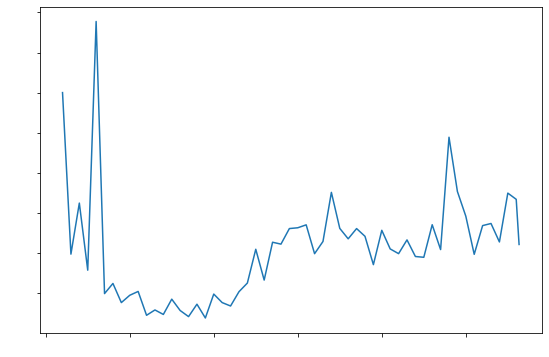

In [56]:
df_origin = pd.read_csv('leader_stocks_data/KT&G_기타제조업.csv')
data_size = list(range(200, len(df_origin), 100))
data_size.append(len(df_origin))
plt.figure(figsize=(9, 6))
plt.plot(data_size, result)
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.show()


In [158]:
df_origin = pd.read_csv(f'leader_stocks_data/{file_list[4]}')
df_origin

,Date,High,Low,Open,Close,Volume,Adj Close
0,2001-12-25,47745.351562,47745.351562,47745.351562,47745.351562,0.0,33765.574219
1,2001-12-26,47745.351562,47745.351562,47745.351562,47745.351562,0.0,33765.574219
2,2001-12-27,47745.351562,47745.351562,47745.351562,47745.351562,0.0,33765.574219
3,2001-12-28,47745.351562,47745.351562,47745.351562,47745.351562,0.0,33765.574219
4,2001-12-31,48723.742188,48723.742188,48723.742188,48723.742188,0.0,34457.492188
...,...,...,...,...,...,...,...
5123,2022-06-20,52800.000000,51100.000000,52600.000000,51400.000000,879936.0,51400.000000
5124,2022-06-21,51500.000000,50600.000000,51400.000000,50800.000000,1269827.0,50800.000000
5125,2022-06-22,51200.000000,48500.000000,51000.000000,48650.000000,2174679.0,48650.000000
5126,2022-06-23,49050.000000,47750.000000,48000.000000,47900.000000,2092984.0,47900.000000


In [209]:
df_origin = pd.read_csv(f'leader_stocks_data/{file_list[4]}')
for column in df_origin.columns[1:]:
    df_origin= df_origin.loc[df_origin[f'{column}'] != 0, :]
df_origin.loc[df_origin['Close'] > 100000, ['High','Low','Open', 'Close', 'Volume','Adj Close' ]] %= 100
df_origin

,Date,High,Low,Open,Close,Volume,Adj Close
1740,2008-10-10,47109.402344,40065.003906,47109.402344,45984.253906,13291017.0,32520.121094
1741,2008-10-13,50387.000000,45543.980469,47109.402344,49604.289062,3246863.0,35080.214844
1742,2008-10-14,54789.750000,50680.519531,52832.972656,51463.230469,4044980.0,36394.863281
1743,2008-10-15,50191.324219,48625.902344,49115.097656,49897.808594,2914254.0,35287.789062
1744,2008-10-16,44956.945312,42462.054688,44663.429688,42462.054688,4028134.0,30029.220703
...,...,...,...,...,...,...,...
5123,2022-06-20,52800.000000,51100.000000,52600.000000,51400.000000,879936.0,51400.000000
5124,2022-06-21,51500.000000,50600.000000,51400.000000,50800.000000,1269827.0,50800.000000
5125,2022-06-22,51200.000000,48500.000000,51000.000000,48650.000000,2174679.0,48650.000000
5126,2022-06-23,49050.000000,47750.000000,48000.000000,47900.000000,2092984.0,47900.000000


In [211]:
df_origin= df_origin.loc[df_origin['High'] != 0, :]

In [212]:
df_origin.min()

Date           2008-10-10
High         24655.386719
Low          21182.109375
Open         22600.771484
Close        22307.255859
Volume           287818.0
Adj Close     15775.71875
dtype: object

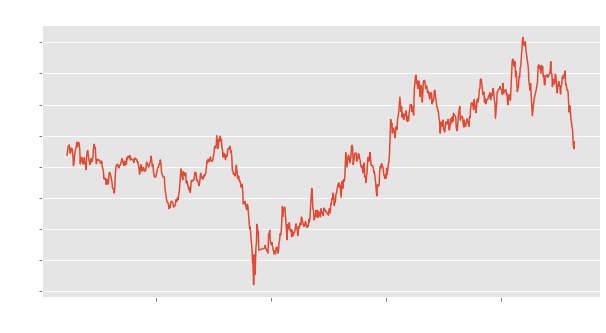

In [213]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize = (10,5))
plt.title("kb증권", fontsize=15, color = 'white')
plt.plot(df_origin[2500:]['Close'], "-", label="Close")
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
ax.xaxis.set_major_locator(plt.MultipleLocator(200))
plt.xticks(rotation=45)
plt.grid(axis = 'x')
plt.show()

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
25/25 [==============================] - 8s 104ms/step - loss: 0.1134 - mse: 0.2269 - val_loss: 0.0985 - val_mse: 0.1971
Epoch 2/50
25/25 [==============================] - 1s 26ms/step - loss: 0.0270 - mse: 0.0540 - val_loss: 8.3646e-04 - val_mse: 0.0017
Epoch 3/50
25/25 [==============================] - 1s 21ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 8.6190e-04 - val_mse: 0.0017
Epoch 4/50
25/25 [==============================] - 1s 21ms/step - loss: 0.0015 - mse: 0.0031 - val_loss: 8.3540e-04 - val_mse: 0.0017
Epoch 5/50
25/25 [==============================] - 1s 20ms/step - loss: 9.7225e-04 - mse: 0.0019 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 6/50
25/25 [==============================] - 1s 20ms/step - loss: 9.3879e-04 - mse: 0.0019 - val_loss: 8.3036e-04 - val_mse: 0.0017
Epoch 7/50
25/25 [==============================] - 1s 21ms/step - loss: 9.5835e-04 - mse: 0.0019 - val_loss: 7.7164e-04 - val_mse: 0.0015
Epoch 8/50
25/25 [==============================] 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
50/50 [==============================] - 6s 35ms/step - loss: 0.0986 - mse: 0.1973 - val_loss: 0.0650 - val_mse: 0.1300
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0054 - mse: 0.0107 - val_loss: 0.0083 - val_mse: 0.0167
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 0.0056 - val_mse: 0.0112
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0035 - val_mse: 0.0070
Epoch 5/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 0.0037 - val_mse: 0.0073
Epoch 6/50
50/50 [==============================] - 1s 17ms/step - loss: 9.3432e-04 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 7/50
50/50 [==============================] - 1s 18ms/step - loss: 8.3118e-04 - mse: 0.0017 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 8/50
50/50 [==============================] - 1s 20ms/step - loss: 7.

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
75/75 [==============================] - 7s 32ms/step - loss: 0.0168 - mse: 0.0336 - val_loss: 0.0084 - val_mse: 0.0168
Epoch 2/50
75/75 [==============================] - 2s 19ms/step - loss: 0.0015 - mse: 0.0029 - val_loss: 0.0039 - val_mse: 0.0078
Epoch 3/50
75/75 [==============================] - 1s 17ms/step - loss: 7.1968e-04 - mse: 0.0014 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 4/50
75/75 [==============================] - 1s 17ms/step - loss: 6.5694e-04 - mse: 0.0013 - val_loss: 0.0020 - val_mse: 0.0040
Epoch 5/50
75/75 [==============================] - 2s 19ms/step - loss: 6.3224e-04 - mse: 0.0013 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 6/50
75/75 [==============================] - 1s 17ms/step - loss: 6.0856e-04 - mse: 0.0012 - val_loss: 0.0018 - val_mse: 0.0035
Epoch 7/50
75/75 [==============================] - 1s 17ms/step - loss: 5.6938e-04 - mse: 0.0011 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 8/50
75/75 [==============================] - 2s 20ms/ste

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
90/90 [==============================] - 7s 29ms/step - loss: 0.0152 - mse: 0.0304 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 2/50
90/90 [==============================] - 2s 20ms/step - loss: 5.8683e-04 - mse: 0.0012 - val_loss: 8.0254e-04 - val_mse: 0.0016
Epoch 3/50
90/90 [==============================] - 2s 19ms/step - loss: 3.4280e-04 - mse: 6.8560e-04 - val_loss: 6.9876e-04 - val_mse: 0.0014
Epoch 4/50
90/90 [==============================] - 2s 19ms/step - loss: 3.2828e-04 - mse: 6.5656e-04 - val_loss: 7.3273e-04 - val_mse: 0.0015
Epoch 5/50
90/90 [==============================] - 2s 17ms/step - loss: 3.1776e-04 - mse: 6.3551e-04 - val_loss: 6.5019e-04 - val_mse: 0.0013
Epoch 6/50
90/90 [==============================] - 2s 17ms/step - loss: 3.1243e-04 - mse: 6.2485e-04 - val_loss: 6.6292e-04 - val_mse: 0.0013
Epoch 7/50
90/90 [==============================] - 2s 16ms/step - loss: 2.9998e-04 - mse: 5.9996e-04 - val_loss: 6.9618e-04 - val_mse: 0.0014
Epoch 8/50
90/9

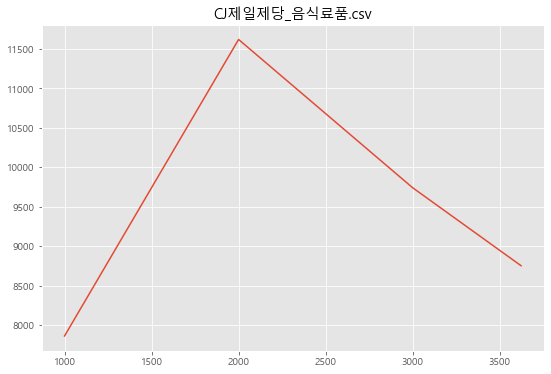

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
6/6 [==============================] - 5s 211ms/step - loss: 0.4025 - mse: 0.8130 - val_loss: 0.1773 - val_mse: 0.3546
Epoch 2/50
6/6 [==============================] - 0s 34ms/step - loss: 0.3427 - mse: 0.6874 - val_loss: 0.1478 - val_mse: 0.2957
Epoch 3/50
6/6 [==============================] - 0s 35ms/step - loss: 0.2942 - mse: 0.5887 - val_loss: 0.1235 - val_mse: 0.2469
Epoch 4/50
6/6 [==============================] - 0s 31ms/step - loss: 0.2535 - mse: 0.5071 - val_loss: 0.1033 - val_mse: 0.2065
Epoch 5/50
6/6 [==============================] - 0s 33ms/step - loss: 0.2187 - mse: 0.4373 - val_loss: 0.0891 - val_mse: 0.1782
Epoch 6/50
6/6 [==============================] - 0s 30ms/step - loss: 0.1922 - mse: 0.3844 - val_loss: 0.0829 - val_mse: 0.1657
Epoch 7/50
6/6 [==============================] - 0s 33ms/step - loss: 0.1737 - mse: 0.3473 - val_loss: 0.0788 - val_mse: 0.1575
Epoch 8/50
6/6 [==============================] - 0s 35ms/step - loss: 0.1638 - mse: 0.3276 - va

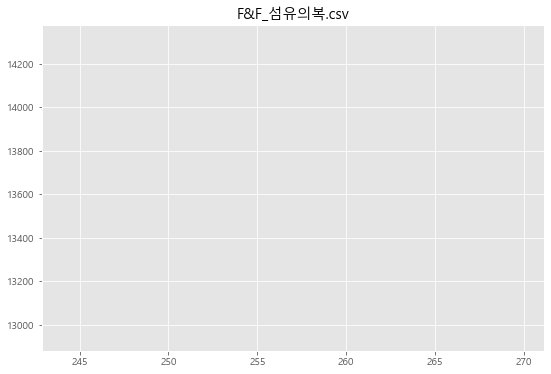

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
25/25 [==============================] - 12s 53ms/step - loss: 0.0139 - mse: 0.0278 - val_loss: 0.0406 - val_mse: 0.0811
Epoch 2/50
25/25 [==============================] - 1s 18ms/step - loss: 0.0040 - mse: 0.0081 - val_loss: 0.0107 - val_mse: 0.0213
Epoch 3/50
25/25 [==============================] - 1s 18ms/step - loss: 0.0024 - mse: 0.0048 - val_loss: 0.0039 - val_mse: 0.0077
Epoch 4/50
25/25 [==============================] - 1s 20ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0061 - val_mse: 0.0121
Epoch 5/50
25/25 [==============================] - 1s 19ms/step - loss: 9.4939e-04 - mse: 0.0019 - val_loss: 0.0092 - val_mse: 0.0183
Epoch 6/50
25/25 [==============================] - 1s 19ms/step - loss: 9.0748e-04 - mse: 0.0018 - val_loss: 0.0085 - val_mse: 0.0171
Epoch 7/50
25/25 [==============================] - 1s 20ms/step - loss: 8.7378e-04 - mse: 0.0017 - val_loss: 0.0076 - val_mse: 0.0152
Epoch 8/50
25/25 [==============================] - 1s 19ms/step - los

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
50/50 [==============================] - 5s 36ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 0.0063 - val_mse: 0.0126
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 2.1783e-04 - mse: 4.3567e-04 - val_loss: 0.0051 - val_mse: 0.0101
Epoch 3/50
50/50 [==============================] - 1s 19ms/step - loss: 1.9036e-04 - mse: 3.8071e-04 - val_loss: 0.0051 - val_mse: 0.0101
Epoch 4/50
50/50 [==============================] - 1s 19ms/step - loss: 1.8226e-04 - mse: 3.6453e-04 - val_loss: 0.0042 - val_mse: 0.0084
Epoch 5/50
50/50 [==============================] - 1s 16ms/step - loss: 1.6918e-04 - mse: 3.3836e-04 - val_loss: 0.0037 - val_mse: 0.0075
Epoch 6/50
50/50 [==============================] - 1s 17ms/step - loss: 1.5977e-04 - mse: 3.1955e-04 - val_loss: 0.0032 - val_mse: 0.0063
Epoch 7/50
50/50 [==============================] - 1s 19ms/step - loss: 1.5326e-04 - mse: 3.0652e-04 - val_loss: 0.0035 - val_mse: 0.0069
Epoch 8/50
50/50 [=================

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
75/75 [==============================] - 7s 31ms/step - loss: 2.9959e-04 - mse: 5.9918e-04 - val_loss: 0.0064 - val_mse: 0.0128
Epoch 2/50
75/75 [==============================] - 1s 16ms/step - loss: 1.1847e-04 - mse: 2.3695e-04 - val_loss: 0.0052 - val_mse: 0.0104
Epoch 3/50
75/75 [==============================] - 1s 16ms/step - loss: 1.0959e-04 - mse: 2.1919e-04 - val_loss: 0.0049 - val_mse: 0.0097
Epoch 4/50
75/75 [==============================] - 1s 16ms/step - loss: 1.0470e-04 - mse: 2.0940e-04 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 5/50
75/75 [==============================] - 2s 21ms/step - loss: 9.5803e-05 - mse: 1.9161e-04 - val_loss: 0.0037 - val_mse: 0.0075
Epoch 6/50
75/75 [==============================] - 2s 19ms/step - loss: 8.8705e-05 - mse: 1.7741e-04 - val_loss: 0.0030 - val_mse: 0.0059
Epoch 7/50
75/75 [==============================] - 2s 19ms/step - loss: 8.0487e-05 - mse: 1.6097e-04 - val_loss: 0.0033 - val_mse: 0.0065
Epoch 8/50
75/75 [=========

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
100/100 [==============================] - 7s 27ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0055
Epoch 2/50
100/100 [==============================] - 2s 17ms/step - loss: 1.1357e-04 - mse: 2.2714e-04 - val_loss: 0.0027 - val_mse: 0.0053
Epoch 3/50
100/100 [==============================] - 2s 18ms/step - loss: 1.0124e-04 - mse: 2.0248e-04 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 4/50
100/100 [==============================] - 2s 18ms/step - loss: 9.3253e-05 - mse: 1.8651e-04 - val_loss: 0.0021 - val_mse: 0.0042
Epoch 5/50
100/100 [==============================] - 2s 22ms/step - loss: 8.6829e-05 - mse: 1.7366e-04 - val_loss: 0.0022 - val_mse: 0.0043
Epoch 6/50
100/100 [==============================] - 2s 20ms/step - loss: 8.1569e-05 - mse: 1.6314e-04 - val_loss: 0.0016 - val_mse: 0.0031
Epoch 7/50
100/100 [==============================] - 2s 18ms/step - loss: 7.2930e-05 - mse: 1.4586e-04 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 8/50
100/100 [=

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
125/125 [==============================] - 7s 23ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 0.0044 - val_mse: 0.0089
Epoch 2/50
125/125 [==============================] - 2s 17ms/step - loss: 1.4967e-04 - mse: 2.9934e-04 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 8.3531e-05 - mse: 1.6706e-04 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 4/50
125/125 [==============================] - 2s 18ms/step - loss: 8.2566e-05 - mse: 1.6513e-04 - val_loss: 0.0015 - val_mse: 0.0031
Epoch 5/50
125/125 [==============================] - 2s 17ms/step - loss: 7.9686e-05 - mse: 1.5937e-04 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 6/50
125/125 [==============================] - 3s 20ms/step - loss: 7.4808e-05 - mse: 1.4962e-04 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 7/50
125/125 [==============================] - 2s 17ms/step - loss: 7.0462e-05 - mse: 1.4092e-04 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 8/50
125/125 [=

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
137/137 [==============================] - 6s 21ms/step - loss: 0.0064 - mse: 0.0129 - val_loss: 0.0021 - val_mse: 0.0042
Epoch 2/50
137/137 [==============================] - 2s 15ms/step - loss: 2.7275e-04 - mse: 5.4550e-04 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 3/50
137/137 [==============================] - 2s 15ms/step - loss: 2.2526e-04 - mse: 4.5052e-04 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 4/50
137/137 [==============================] - 2s 15ms/step - loss: 2.1882e-04 - mse: 4.3763e-04 - val_loss: 0.0011 - val_mse: 0.0023
Epoch 5/50
137/137 [==============================] - 2s 17ms/step - loss: 1.9845e-04 - mse: 3.9690e-04 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 6/50
137/137 [==============================] - 3s 20ms/step - loss: 1.9228e-04 - mse: 3.8456e-04 - val_loss: 9.9831e-04 - val_mse: 0.0020
Epoch 7/50
137/137 [==============================] - 2s 15ms/step - loss: 1.8071e-04 - mse: 3.6142e-04 - val_loss: 9.5450e-04 - val_mse: 0.0019
Epoch 8/50
13

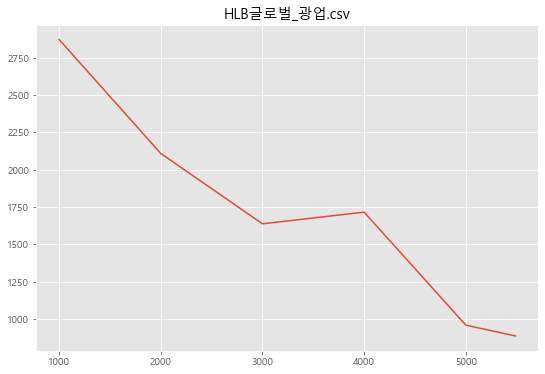

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
25/25 [==============================] - 5s 53ms/step - loss: 0.0384 - mse: 0.0768 - val_loss: 0.0638 - val_mse: 0.1276
Epoch 2/50
25/25 [==============================] - 1s 19ms/step - loss: 0.0133 - mse: 0.0266 - val_loss: 0.0078 - val_mse: 0.0156
Epoch 3/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0038 - mse: 0.0075 - val_loss: 0.0022 - val_mse: 0.0043
Epoch 4/50
25/25 [==============================] - 0s 17ms/step - loss: 4.9230e-04 - mse: 9.8459e-04 - val_loss: 0.0086 - val_mse: 0.0172
Epoch 5/50
25/25 [==============================] - 1s 27ms/step - loss: 3.2064e-04 - mse: 6.4128e-04 - val_loss: 0.0064 - val_mse: 0.0128
Epoch 6/50
25/25 [==============================] - 1s 23ms/step - loss: 2.9943e-04 - mse: 5.9886e-04 - val_loss: 0.0069 - val_mse: 0.0138
Epoch 7/50
25/25 [==============================] - 1s 21ms/step - loss: 2.9939e-04 - mse: 5.9878e-04 - val_loss: 0.0067 - val_mse: 0.0134
Epoch 8/50
25/25 [==============================] -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
50/50 [==============================] - 6s 45ms/step - loss: 0.0169 - mse: 0.0338 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 2/50
50/50 [==============================] - 1s 22ms/step - loss: 5.0489e-04 - mse: 0.0010 - val_loss: 5.3263e-04 - val_mse: 0.0011
Epoch 3/50
50/50 [==============================] - 2s 26ms/step - loss: 3.5310e-04 - mse: 7.0619e-04 - val_loss: 6.1468e-04 - val_mse: 0.0012
Epoch 4/50
50/50 [==============================] - 1s 21ms/step - loss: 3.3800e-04 - mse: 6.7601e-04 - val_loss: 6.9514e-04 - val_mse: 0.0014
Epoch 5/50
50/50 [==============================] - 1s 20ms/step - loss: 3.2548e-04 - mse: 6.5095e-04 - val_loss: 5.4082e-04 - val_mse: 0.0011
Epoch 6/50
50/50 [==============================] - 1s 20ms/step - loss: 3.2768e-04 - mse: 6.5536e-04 - val_loss: 5.8494e-04 - val_mse: 0.0012
Epoch 7/50
50/50 [==============================] - 2s 38ms/step - loss: 3.1182e-04 - mse: 6.2363e-04 - val_loss: 5.7177e-04 - val_mse: 0.0011
Epoch 8/50
50/5

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
75/75 [==============================] - 12s 67ms/step - loss: 0.0444 - mse: 0.0887 - val_loss: 0.0016 - val_mse: 0.0033
Epoch 2/50
75/75 [==============================] - 2s 25ms/step - loss: 0.0060 - mse: 0.0120 - val_loss: 2.9393e-04 - val_mse: 5.8786e-04
Epoch 3/50
75/75 [==============================] - 1s 17ms/step - loss: 3.7113e-04 - mse: 7.4227e-04 - val_loss: 6.5139e-05 - val_mse: 1.3028e-04
Epoch 4/50
75/75 [==============================] - 1s 17ms/step - loss: 3.4623e-04 - mse: 6.9247e-04 - val_loss: 5.0241e-05 - val_mse: 1.0048e-04
Epoch 5/50
75/75 [==============================] - 2s 19ms/step - loss: 3.3126e-04 - mse: 6.6253e-04 - val_loss: 4.8717e-05 - val_mse: 9.7433e-05
Epoch 6/50
75/75 [==============================] - 2s 21ms/step - loss: 3.1759e-04 - mse: 6.3518e-04 - val_loss: 4.8575e-05 - val_mse: 9.7151e-05
Epoch 7/50
75/75 [==============================] - 2s 26ms/step - loss: 3.2022e-04 - mse: 6.4044e-04 - val_loss: 3.1018e-05 - val_mse: 6.203

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
100/100 [==============================] - 6s 25ms/step - loss: 0.0405 - mse: 0.0809 - val_loss: 4.9159e-04 - val_mse: 9.8317e-04
Epoch 2/50
100/100 [==============================] - 2s 24ms/step - loss: 5.7565e-04 - mse: 0.0012 - val_loss: 2.2982e-05 - val_mse: 4.5964e-05
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 4.7271e-04 - mse: 9.4542e-04 - val_loss: 2.3266e-05 - val_mse: 4.6533e-05
Epoch 4/50
100/100 [==============================] - 2s 20ms/step - loss: 4.5096e-04 - mse: 9.0192e-04 - val_loss: 2.3066e-05 - val_mse: 4.6133e-05
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - loss: 4.2955e-04 - mse: 8.5911e-04 - val_loss: 2.5013e-05 - val_mse: 5.0025e-05
Epoch 6/50
100/100 [==============================] - 2s 19ms/step - loss: 4.1766e-04 - mse: 8.3532e-04 - val_loss: 2.4179e-05 - val_mse: 4.8359e-05
Epoch 7/50
100/100 [==============================] - 2s 16ms/step - loss: 4.0054e-04 - mse: 8.0108e-04 - val_loss: 2.

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
125/125 [==============================] - 6s 22ms/step - loss: 0.0056 - mse: 0.0112 - val_loss: 5.3380e-05 - val_mse: 1.0676e-04
Epoch 2/50
125/125 [==============================] - 2s 16ms/step - loss: 5.2562e-04 - mse: 0.0011 - val_loss: 3.1675e-05 - val_mse: 6.3350e-05
Epoch 3/50
125/125 [==============================] - 2s 14ms/step - loss: 4.8496e-04 - mse: 9.6991e-04 - val_loss: 2.8417e-05 - val_mse: 5.6833e-05
Epoch 4/50
125/125 [==============================] - 2s 15ms/step - loss: 4.7563e-04 - mse: 9.5127e-04 - val_loss: 2.9096e-05 - val_mse: 5.8192e-05
Epoch 5/50
125/125 [==============================] - 2s 19ms/step - loss: 4.2126e-04 - mse: 8.4251e-04 - val_loss: 2.2743e-05 - val_mse: 4.5486e-05
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 3.8054e-04 - mse: 7.6107e-04 - val_loss: 2.5807e-05 - val_mse: 5.1613e-05
Epoch 7/50
125/125 [==============================] - 2s 17ms/step - loss: 3.3242e-04 - mse: 6.6485e-04 - val_loss: 2.

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
137/137 [==============================] - 6s 21ms/step - loss: 7.0367e-04 - mse: 0.0014 - val_loss: 1.9237e-05 - val_mse: 3.8475e-05
Epoch 2/50
137/137 [==============================] - 2s 15ms/step - loss: 3.0709e-04 - mse: 6.1418e-04 - val_loss: 3.1967e-05 - val_mse: 6.3933e-05
Epoch 3/50
137/137 [==============================] - 2s 15ms/step - loss: 2.7780e-04 - mse: 5.5561e-04 - val_loss: 1.0454e-05 - val_mse: 2.0908e-05
Epoch 4/50
137/137 [==============================] - 2s 15ms/step - loss: 2.6088e-04 - mse: 5.2176e-04 - val_loss: 8.9496e-06 - val_mse: 1.7899e-05
Epoch 5/50
137/137 [==============================] - 2s 16ms/step - loss: 2.4345e-04 - mse: 4.8690e-04 - val_loss: 8.8424e-06 - val_mse: 1.7685e-05
Epoch 6/50
137/137 [==============================] - 2s 17ms/step - loss: 2.2141e-04 - mse: 4.4282e-04 - val_loss: 9.1235e-06 - val_mse: 1.8247e-05
Epoch 7/50
137/137 [==============================] - 2s 15ms/step - loss: 1.9735e-04 - mse: 3.9469e-04 - val_

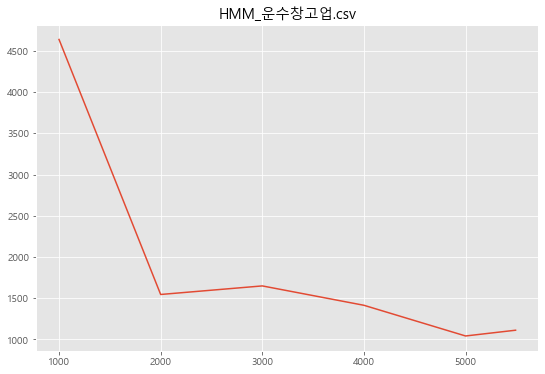

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
25/25 [==============================] - 5s 51ms/step - loss: 0.0048 - mse: 0.0096 - val_loss: 6.1655e-06 - val_mse: 1.2331e-05
Epoch 2/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0044 - mse: 0.0087 - val_loss: 8.2823e-06 - val_mse: 1.6565e-05
Epoch 3/50
25/25 [==============================] - 1s 18ms/step - loss: 0.0040 - mse: 0.0080 - val_loss: 4.0636e-05 - val_mse: 8.1271e-05
Epoch 4/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0037 - mse: 0.0075 - val_loss: 1.6843e-05 - val_mse: 3.3686e-05
Epoch 5/50
25/25 [==============================] - 0s 15ms/step - loss: 0.0034 - mse: 0.0068 - val_loss: 8.5262e-07 - val_mse: 1.7052e-06
Epoch 6/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0031 - mse: 0.0061 - val_loss: 8.0153e-05 - val_mse: 1.6031e-04
Epoch 7/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 2.1533e-06 - val_mse: 4.3066e-06
Epoch 8/50
25/25 [=========

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
50/50 [==============================] - 5s 33ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 3.2857e-06 - val_mse: 6.5714e-06
Epoch 2/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0022 - mse: 0.0045 - val_loss: 2.5166e-06 - val_mse: 5.0331e-06
Epoch 3/50
50/50 [==============================] - 1s 18ms/step - loss: 0.0021 - mse: 0.0042 - val_loss: 1.6622e-06 - val_mse: 3.3244e-06
Epoch 4/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 4.5408e-05 - val_mse: 9.0815e-05
Epoch 5/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 9.5477e-07 - val_mse: 1.9095e-06
Epoch 6/50
50/50 [==============================] - 1s 21ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 2.9264e-06 - val_mse: 5.8528e-06
Epoch 7/50
50/50 [==============================] - 1s 21ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 6.9166e-06 - val_mse: 1.3833e-05
Epoch 8/50
50/50 [=========

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
75/75 [==============================] - 5s 26ms/step - loss: 2.1612e-06 - mse: 4.3225e-06 - val_loss: 0.0075 - val_mse: 0.0150
Epoch 2/50
75/75 [==============================] - 1s 15ms/step - loss: 8.8175e-07 - mse: 1.7635e-06 - val_loss: 0.0069 - val_mse: 0.0139
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 1.9043e-07 - mse: 3.8086e-07 - val_loss: 0.0068 - val_mse: 0.0136
Epoch 4/50
75/75 [==============================] - 1s 15ms/step - loss: 1.0076e-07 - mse: 2.0152e-07 - val_loss: 0.0068 - val_mse: 0.0135
Epoch 5/50
75/75 [==============================] - 2s 19ms/step - loss: 1.0658e-07 - mse: 2.1316e-07 - val_loss: 0.0067 - val_mse: 0.0135
Epoch 6/50
75/75 [==============================] - 1s 17ms/step - loss: 1.2483e-07 - mse: 2.4966e-07 - val_loss: 0.0067 - val_mse: 0.0134
Epoch 7/50
75/75 [==============================] - 1s 17ms/step - loss: 1.2682e-07 - mse: 2.5364e-07 - val_loss: 0.0067 - val_mse: 0.0133
Epoch 8/50
75/75 [=========

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
84/84 [==============================] - 7s 26ms/step - loss: 1.7122e-06 - mse: 3.4244e-06 - val_loss: 0.0059 - val_mse: 0.0118
Epoch 2/50
84/84 [==============================] - 2s 17ms/step - loss: 3.4425e-07 - mse: 6.8849e-07 - val_loss: 0.0055 - val_mse: 0.0111
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1138e-07 - mse: 2.2277e-07 - val_loss: 0.0055 - val_mse: 0.0109
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0805e-07 - mse: 2.1609e-07 - val_loss: 0.0054 - val_mse: 0.0109
Epoch 5/50
84/84 [==============================] - 1s 16ms/step - loss: 1.0601e-07 - mse: 2.1203e-07 - val_loss: 0.0054 - val_mse: 0.0108
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1961e-07 - mse: 2.3923e-07 - val_loss: 0.0054 - val_mse: 0.0108
Epoch 7/50
84/84 [==============================] - 1s 16ms/step - loss: 1.1259e-07 - mse: 2.2519e-07 - val_loss: 0.0054 - val_mse: 0.0107
Epoch 8/50
84/84 [=========

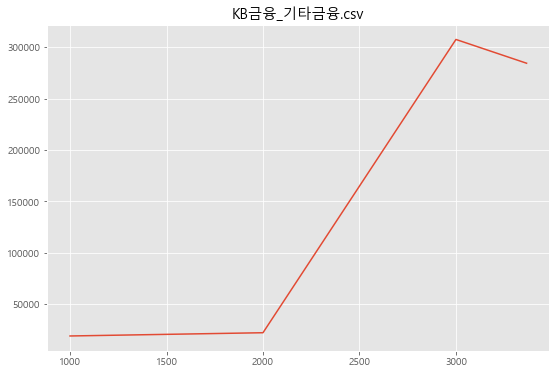

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
25/25 [==============================] - 5s 52ms/step - loss: 0.1561 - mse: 0.3121 - val_loss: 0.0489 - val_mse: 0.0977
Epoch 2/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0174 - mse: 0.0347 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 3/50
25/25 [==============================] - 1s 17ms/step - loss: 0.0030 - mse: 0.0059 - val_loss: 5.0883e-04 - val_mse: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 5.2474e-04 - val_mse: 0.0010
Epoch 5/50
25/25 [==============================] - 1s 19ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 4.3058e-04 - val_mse: 8.6115e-04
Epoch 6/50
25/25 [==============================] - 0s 14ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 4.9982e-04 - val_mse: 9.9963e-04
Epoch 7/50
25/25 [==============================] - 0s 14ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 4.0774e-04 - val_mse: 8.1548e-04
Epoch 8/50
25/25 [==============================] -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
50/50 [==============================] - 5s 32ms/step - loss: 0.0807 - mse: 0.1613 - val_loss: 0.0125 - val_mse: 0.0250
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0086 - mse: 0.0172 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 3/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0035 - mse: 0.0069 - val_loss: 6.8834e-04 - val_mse: 0.0014
Epoch 4/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0022 - mse: 0.0043 - val_loss: 6.0465e-04 - val_mse: 0.0012
Epoch 5/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0016 - mse: 0.0033 - val_loss: 2.5795e-04 - val_mse: 5.1591e-04
Epoch 6/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0014 - mse: 0.0029 - val_loss: 2.4741e-04 - val_mse: 4.9483e-04
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 2.4771e-04 - val_mse: 4.9543e-04
Epoch 8/50
50/50 [==============================] -

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
75/75 [==============================] - 6s 28ms/step - loss: 0.0291 - mse: 0.0581 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 2/50
75/75 [==============================] - 1s 17ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 4.8607e-04 - val_mse: 9.7215e-04
Epoch 3/50
75/75 [==============================] - 1s 16ms/step - loss: 4.9242e-04 - mse: 9.8483e-04 - val_loss: 4.3414e-04 - val_mse: 8.6828e-04
Epoch 4/50
75/75 [==============================] - 1s 16ms/step - loss: 3.7825e-04 - mse: 7.5651e-04 - val_loss: 4.3073e-04 - val_mse: 8.6145e-04
Epoch 5/50
75/75 [==============================] - 2s 18ms/step - loss: 3.5411e-04 - mse: 7.0821e-04 - val_loss: 4.1325e-04 - val_mse: 8.2649e-04
Epoch 6/50
75/75 [==============================] - 1s 17ms/step - loss: 3.3405e-04 - mse: 6.6811e-04 - val_loss: 3.2779e-04 - val_mse: 6.5559e-04
Epoch 7/50
75/75 [==============================] - 1s 18ms/step - loss: 3.2262e-04 - mse: 6.4525e-04 - val_loss: 3.5283e-04 - val_mse: 7.0566

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
100/100 [==============================] - 8s 31ms/step - loss: 0.0020 - mse: 0.0041 - val_loss: 2.8571e-04 - val_mse: 5.7142e-04
Epoch 2/50
100/100 [==============================] - 2s 18ms/step - loss: 2.7657e-04 - mse: 5.5313e-04 - val_loss: 2.7530e-04 - val_mse: 5.5060e-04
Epoch 3/50
100/100 [==============================] - 2s 18ms/step - loss: 2.6285e-04 - mse: 5.2570e-04 - val_loss: 2.4270e-04 - val_mse: 4.8540e-04
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 2.4438e-04 - mse: 4.8876e-04 - val_loss: 2.6254e-04 - val_mse: 5.2508e-04
Epoch 5/50
100/100 [==============================] - 2s 18ms/step - loss: 2.3176e-04 - mse: 4.6352e-04 - val_loss: 2.3253e-04 - val_mse: 4.6506e-04
Epoch 6/50
100/100 [==============================] - 2s 19ms/step - loss: 2.2134e-04 - mse: 4.4267e-04 - val_loss: 2.2313e-04 - val_mse: 4.4625e-04
Epoch 7/50
100/100 [==============================] - 2s 17ms/step - loss: 2.3206e-04 - mse: 4.6411e-04 - val_loss

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
125/125 [==============================] - 7s 21ms/step - loss: 4.4322e-04 - mse: 8.8644e-04 - val_loss: 2.1330e-04 - val_mse: 4.2660e-04
Epoch 2/50
125/125 [==============================] - 2s 15ms/step - loss: 1.3431e-04 - mse: 2.6862e-04 - val_loss: 1.5531e-04 - val_mse: 3.1062e-04
Epoch 3/50
125/125 [==============================] - 3s 20ms/step - loss: 1.2333e-04 - mse: 2.4666e-04 - val_loss: 2.0870e-04 - val_mse: 4.1740e-04
Epoch 4/50
125/125 [==============================] - 2s 17ms/step - loss: 1.1764e-04 - mse: 2.3527e-04 - val_loss: 1.4093e-04 - val_mse: 2.8186e-04
Epoch 5/50
125/125 [==============================] - 2s 15ms/step - loss: 1.0390e-04 - mse: 2.0780e-04 - val_loss: 1.2922e-04 - val_mse: 2.5844e-04
Epoch 6/50
125/125 [==============================] - 2s 16ms/step - loss: 1.0113e-04 - mse: 2.0226e-04 - val_loss: 1.6495e-04 - val_mse: 3.2991e-04
Epoch 7/50
125/125 [==============================] - 2s 15ms/step - loss: 9.7205e-05 - mse: 1.9441e-04 - 

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23124\2978139252.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)


Epoch 1/50
138/138 [==============================] - 6s 22ms/step - loss: 3.4378e-04 - mse: 6.8757e-04 - val_loss: 2.3451e-04 - val_mse: 4.6902e-04
Epoch 2/50
138/138 [==============================] - 3s 18ms/step - loss: 1.2744e-04 - mse: 2.5487e-04 - val_loss: 2.4043e-04 - val_mse: 4.8086e-04
Epoch 3/50
138/138 [==============================] - 3s 19ms/step - loss: 1.3736e-04 - mse: 2.7471e-04 - val_loss: 2.6350e-04 - val_mse: 5.2700e-04
Epoch 4/50
138/138 [==============================] - 2s 16ms/step - loss: 1.0811e-04 - mse: 2.1622e-04 - val_loss: 3.4361e-04 - val_mse: 6.8722e-04
Epoch 5/50
138/138 [==============================] - 2s 16ms/step - loss: 1.2589e-04 - mse: 2.5178e-04 - val_loss: 2.9550e-04 - val_mse: 5.9100e-04
Epoch 6/50
138/138 [==============================] - 2s 16ms/step - loss: 1.1027e-04 - mse: 2.2054e-04 - val_loss: 3.9094e-04 - val_mse: 7.8188e-04
Epoch 7/50
138/138 [==============================] - 2s 17ms/step - loss: 1.0112e-04 - mse: 2.0223e-04 - 

KeyboardInterrupt: 

In [215]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)
import os
file_list = os.listdir('leader_stocks_data')


WINDOW_SIZE=20
BATCH_SIZE=32
for file_name in file_list:
    result = []
    df_origin = pd.read_csv(f'leader_stocks_data/{file_name}')
    # 결측치(0인 값) 있는 행 제거
    for column in df_origin.columns:
        df_origin= df_origin[df_origin[f'{column}'] != 0]
    for i in range(1, len(df_origin)//1000+2):
        # 데이터 불러오기
        df = df_origin
        df = df.set_index(keys=['Date'], inplace=False, drop=True)
        df = df.drop('Close', axis = 1)
        df.rename(columns ={'Adj Close':'Close'}, inplace = True)
        # 원하는 크기로 데이터 자르기
        df = df[-i*1000:]
        # 피처값, 타켓 스케일링
        scaler = MinMaxScaler()
        df[['High','Low','Open', 'Volume']] = scaler.fit_transform(df[['High','Low','Open', 'Volume']])
        df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
        # train, test set 분리
        x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, shuffle=False)
        train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
        test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False) 
        # lstm 모델링
        model = Sequential([
            Conv1D(filters=32, kernel_size=5,
                   padding="causal",
                   activation="relu",
                   input_shape=[WINDOW_SIZE, 1]),
            LSTM(16, activation='tanh'),
            Dense(16, activation="relu"),
            Dense(1),
        ])
        loss = Huber()
        optimizer = Adam(0.0005)
        model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse']) 
        earlystopping = EarlyStopping(monitor='val_loss', patience=10) 
        # lstm 적용                                        
        history = model.fit(train_data, 
                            validation_data=(test_data), 
                            epochs=50, 
                            callbacks=[earlystopping])
        pred = model.predict(test_data)
        # rescaleing 작업
        rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
        rescaled_pred = scaler.inverse_transform(np.array(pred).reshape(-1,1))
        # 평가지표(RMSE) 계산
        RMSE = np.sqrt(mean_squared_error(rescaled_y_test[20:], rescaled_pred))
        result.append(RMSE)
        print(f"{file_name}")
        print(f"{i * 1000}길이의 데이터 적용 완료\n 길이: {i * 1000}, RMSE:{RMSE}")
        print(result)
    data_size = list(range(1000, len(df_origin), 1000))
    data_size.append(len(df_origin))
    plt.style.use("ggplot")
    plt.rcParams['font.family'] = 'Malgun Gothic'
    data_size = list(range(1000, len(df_origin), 1000))
    data_size.append(len(df_origin))
    plt.figure(figsize=(9, 6))
    plt.plot(data_size, result)
    plt.tick_params(axis='x')
    plt.tick_params(axis='y')
    plt.title(f'{file_name}')
    plt.show()

### 회귀모델 적용

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()
X = df[['High','Low','Open', 'Volume']]
Y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=10)
print('훈련 데이터: ', X_train.shape)
print('검증 데이터:', X_test.shape)


훈련 데이터:  (443, 4)
검증 데이터: (191, 4)


In [64]:
lr.fit(X_train,y_train)
r_square = lr.score(X_test, y_test)
r_square 

0.5035778758992044

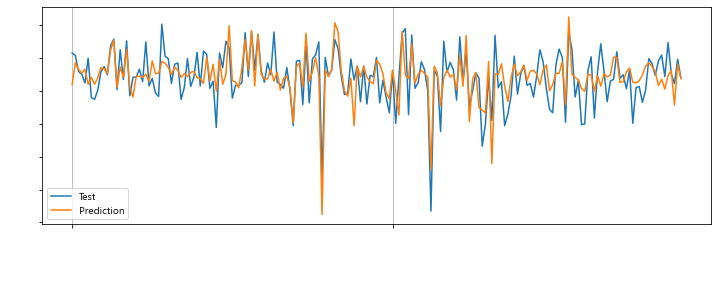

In [65]:
y_hat = lr.predict(X_test)

fig, axes = plt.subplots(figsize=(12, 4))
#axes.plot(y_train, label='Train')        # 훈련 데이터
axes.plot(y_test, label='Test')          # 테스트 데이터
axes.plot(y_test.index, y_hat, label='Prediction')  # 예측 데이터
axes.xaxis.set_major_locator(plt.MultipleLocator(100))
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.xticks(rotation=45)
plt.grid(axis = 'x')
plt.legend()
plt.show()

In [66]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_hat):.3f}")

def MPE(y_test, y_pred): 
    return np.mean((y_test - y_pred) / y_test) * 100
print(f"MPE: {MPE(y_test, y_hat):.3f}")

def MAE(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

print(f"MAE: {MAE(y_test, y_hat):.3f}")

def MSE(y_test, y_pred):
    return np.mean(np.square((y_test - y_pred)))

print(f"MSE: {MSE(y_test, y_hat):.3f}")

print(f"RMSE: {np.sqrt(MSE(y_test, y_hat)):.3f}")

MAPE: 2.866
MPE: -0.264
MAE: 2177.710
MSE: 8166861.082
RMSE: 2857.772
